In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ASNA-hackathon/sample_submission.csv
/kaggle/input/ASNA-hackathon/train.csv
/kaggle/input/ASNA-hackathon/test.csv


In [2]:
#Importing packages
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_validate, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, auc, f1_score, roc_curve, roc_auc_score, classification_report, precision_recall_curve, accuracy_score
from imblearn.ensemble import BalancedRandomForestClassifier
import xgboost
from lightgbm import LGBMClassifier
from statistics import mean
import matplotlib.pyplot as plt
import warnings
import math


# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, auc, f1_score, roc_curve, roc_auc_score, classification_report, precision_recall_curve, accuracy_score
from imblearn.ensemble import BalancedRandomForestClassifier
import xgboost
from lightgbm import LGBMClassifier
from statistics import mean
import warnings
import math

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve, auc,
    ConfusionMatrixDisplay
)
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import confusion_matrix, precision_score, recall_score, auc, f1_score, roc_curve, roc_auc_score, classification_report, precision_recall_curve, accuracy_score
from imblearn.ensemble import BalancedRandomForestClassifier
import xgboost
from lightgbm import LGBMClassifier

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ASNA-hackathon/sample_submission.csv
/kaggle/input/ASNA-hackathon/train.csv
/kaggle/input/ASNA-hackathon/test.csv


In [3]:
df_train = pd.read_csv("/kaggle/input/ASNA-hackathon/train.csv") #7290
df_test = pd.read_csv("/kaggle/input/ASNA-hackathon/test.csv") #1844

In [4]:
# # external data
# df_insurance_external = pd.read_csv('/kaggle/input/insurance-claims-and-policy-data/insurance_dataset.csv')
# df_synthetic_external = pd.read_csv('/kaggle/input/insurance-claims-and-policy-data/data_synthetic.csv')

In [5]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [6]:
df_train['Claim over 1k'].value_counts()

Claim over 1k
0    6458
1     832
Name: count, dtype: int64

In [7]:
for c in df_train.columns:
    if c != 'Effective To Date':
        col_type = df_train[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            df_train[c] = df_train[c].astype('category')

for c in df_test.columns:
    if c != 'Effective To Date':
        col_type = df_test[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            df_test[c] = df_test[c].astype('category')

In [8]:
cols_with_missing = [col for col in df_train.columns 
                                 if df_train[col].isnull().any()]                                  
candidate_train_predictors = df_train.drop(['CustomerID', 'Claim over 1k', 'Coverage', 'Education', 'Employment Status Index', 'Marital Status Index', 'Policy Type Index', 'Policy Index', 'Sales Channel Index', 'Vehicle Size'] + cols_with_missing, axis=1)
candidate_test_predictors = df_test.drop(['CustomerID', 'Coverage', 'Education', 'Employment Status Index', 'Marital Status Index', 'Policy Type Index', 'Policy Index', 'Sales Channel Index', 'Vehicle Size'] + cols_with_missing, axis=1)

In [9]:
candidate_train_predictors['Effective To Date'] = pd.to_datetime(candidate_train_predictors['Effective To Date'])
candidate_train_predictors['Current Date'] = '10/1/2024'
candidate_train_predictors['Current Date'] = pd.to_datetime(candidate_train_predictors['Current Date'])

# create new columns
candidate_train_predictors['clv_avg'] = candidate_train_predictors['Customer Lifetime Value'] / candidate_train_predictors['Months Since Policy Inception']
candidate_train_predictors['complaints_avg'] = candidate_train_predictors['Number of Open Complaints'] / candidate_train_predictors['Number of Policies']
candidate_train_predictors = candidate_train_predictors.drop(['Number of Open Complaints'], axis=1)
candidate_train_predictors['Policy Age (in months)'] = ((candidate_train_predictors['Current Date'] - candidate_train_predictors['Effective To Date']) / pd.Timedelta(days=30.44)).astype(int)
candidate_train_predictors = candidate_train_predictors.drop(['Current Date', 'Effective To Date'], axis=1)
# remove noise
candidate_train_predictors = candidate_train_predictors.drop(['State', 'Policy', 'Sales Channel', 'Renew Offer Type', 'Policy Type'], axis=1)

In [10]:
candidate_test_predictors['Effective To Date'] = pd.to_datetime(candidate_test_predictors['Effective To Date'])
candidate_test_predictors['Current Date'] = '10/1/2024'
candidate_test_predictors['Current Date'] = pd.to_datetime(candidate_test_predictors['Current Date'])

# create new columns
candidate_test_predictors['clv_avg'] = candidate_test_predictors['Customer Lifetime Value'] / candidate_test_predictors['Months Since Policy Inception']
candidate_test_predictors['complaints_avg'] = candidate_test_predictors['Number of Open Complaints'] / candidate_test_predictors['Number of Policies']
candidate_test_predictors = candidate_test_predictors.drop(['Number of Open Complaints'], axis=1)
candidate_test_predictors['Policy Age (in months)'] = ((candidate_test_predictors['Current Date'] - candidate_test_predictors['Effective To Date']) / pd.Timedelta(days=30.44)).astype(int)
candidate_test_predictors = candidate_test_predictors.drop(['Current Date', 'Effective To Date'], axis=1)
# remove noise
candidate_test_predictors = candidate_test_predictors.drop(['State', 'Policy', 'Sales Channel', 'Renew Offer Type', 'Policy Type'], axis=1)

In [11]:
candidate_train_predictors

,Customer Lifetime Value,Response,Coverage Index,Education Index,Employment Status,Gender,Income,Marital Status,Months Since Last Claim,Months Since Policy Inception,Number of Policies,Vehicle Size Index,clv_avg,complaints_avg,Policy Age (in months)
0,3622.69,No,0,2,Employed,F,65163,Married,4,107,1,1,33.856916,3.0,9
1,10610.21,No,0,0,Unemployed,M,0,Single,26,14,7,1,757.872143,0.0,9
2,13868.02,No,1,1,Employed,M,81196,Single,11,38,3,1,364.947895,0.0,9
3,3119.69,No,0,2,Unemployed,F,0,Single,16,32,1,1,97.490313,0.0,9
4,5999.04,No,2,2,Employed,M,62618,Married,45,126,1,1,47.611429,0.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7285,27500.54,No,0,2,Unemployed,F,0,Single,0,28,2,1,982.162143,0.5,0
7286,11750.03,No,0,3,Employed,F,83561,Married,9,107,2,1,109.813364,0.0,0
7287,7757.04,No,0,2,Employed,F,69302,Married,23,119,9,1,65.185210,0.0,0
7288,3465.16,No,0,0,Employed,F,28856,Married,19,89,1,2,38.934382,0.0,0


## Feature engineering

In [12]:
# # engineer some columns
# # clv is determine by customer value * avg customer lifespan -> want to get the Customer Value column, since we know avg customer lifespan is the months since policy inception
candidate_train_predictors['Customer Value'] = np.where(candidate_train_predictors['Months Since Policy Inception'] != 0, candidate_train_predictors['Customer Lifetime Value'] / candidate_train_predictors['Months Since Policy Inception'], 0)
candidate_test_predictors['Customer Value'] = np.where(candidate_test_predictors['Months Since Policy Inception'] != 0, candidate_test_predictors['Customer Lifetime Value'] / candidate_test_predictors['Months Since Policy Inception'], 0)

#### Engineer a new feature, then do a LRT to check whether we should add the new feature

In [13]:
candidate_train_predictors_encoded_sample = candidate_train_predictors.copy()

In [14]:
candidate_train_predictors_encoded_sample = pd.get_dummies(candidate_train_predictors_encoded_sample)
candidate_train_predictors_encoded_sample

,Customer Lifetime Value,Coverage Index,Education Index,Income,Months Since Last Claim,Months Since Policy Inception,Number of Policies,Vehicle Size Index,clv_avg,complaints_avg,Policy Age (in months),Customer Value,Response_No,Response_Yes,Employment Status_Disabled,Employment Status_Employed,Employment Status_Medical Leave,Employment Status_Retired,Employment Status_Unemployed,Gender_F,Gender_M,Marital Status_Divorced,Marital Status_Married,Marital Status_Single
0,3622.69,0,2,65163,4,107,1,1,33.856916,3.0,9,33.856916,True,False,False,True,False,False,False,True,False,False,True,False
1,10610.21,0,0,0,26,14,7,1,757.872143,0.0,9,757.872143,True,False,False,False,False,False,True,False,True,False,False,True
2,13868.02,1,1,81196,11,38,3,1,364.947895,0.0,9,364.947895,True,False,False,True,False,False,False,False,True,False,False,True
3,3119.69,0,2,0,16,32,1,1,97.490313,0.0,9,97.490313,True,False,False,False,False,False,True,True,False,False,False,True
4,5999.04,2,2,62618,45,126,1,1,47.611429,0.0,9,47.611429,True,False,False,True,False,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7285,27500.54,0,2,0,0,28,2,1,982.162143,0.5,0,982.162143,True,False,False,False,False,False,True,True,False,False,False,True
7286,11750.03,0,3,83561,9,107,2,1,109.813364,0.0,0,109.813364,True,False,False,True,False,False,False,True,False,False,True,False
7287,7757.04,0,2,69302,23,119,9,1,65.185210,0.0,0,65.185210,True,False,False,True,False,False,False,True,False,False,True,False
7288,3465.16,0,0,28856,19,89,1,2,38.934382,0.0,0,38.934382,True,False,False,True,False,False,False,True,False,False,True,False


In [15]:
# correlation_matrix = candidate_train_predictors_encoded_sample.corr()
# print(correlation_matrix['Months Since Last Claim'].sort_values(ascending=False))

# corr_matrix_months_since_last_claim = correlation_matrix[['Months Since Last Claim']]

In [16]:
# scaler = StandardScaler()
# df_encoded_sample['Customer'] = scaler.fit_transform(df_encoded_sample_standardized)
# df_encoded_sample = pd.DataFrame(df_encoded_sample_standardized, columns)


# train a simple logistic regression model to get the coefficient for the risk factor based on columns correlated with months since last claim
y_risk_factor = df_train['Claim over 1k']
X_risk_factor = candidate_train_predictors_encoded_sample[['Months Since Last Claim', 'Customer Value', 'Number of Policies', 'Months Since Policy Inception']]


X_risk_factor_train, X_risk_factor_val, y_risk_factor_train, y_risk_factor_val = train_test_split(X_risk_factor, y_risk_factor, test_size=0.2, random_state=314)

feat_eng_clf = LogisticRegression(max_iter=1000)
feat_eng_clf.fit(X_risk_factor_train, y_risk_factor_train)

LogisticRegression(max_iter=1000)

In [17]:
# coeff for risk score
betas = feat_eng_clf.coef_[0]
intercept = feat_eng_clf.intercept_[0]
print(betas, intercept)

[4.14889936e-04 5.85734626e-05 3.53113049e-03 1.83436900e-03] -2.2403690253346453


In [18]:
candidate_train_predictors['Risk Score'] = intercept + (betas[0] * candidate_train_predictors['Months Since Last Claim'] + betas[1] * candidate_train_predictors['Customer Value'] + betas[2] * candidate_train_predictors['Number of Policies'] + betas[3] * candidate_train_predictors['Months Since Policy Inception'])
# sigmoid function as probability of risk score
candidate_train_predictors['Risk Score Probability'] = 1 / (1 + np.exp(-candidate_train_predictors['Risk Score']))

candidate_test_predictors['Risk Score'] = intercept + (betas[0] * candidate_test_predictors['Months Since Last Claim'] + betas[1] * candidate_test_predictors['Customer Value'] + betas[2] * candidate_test_predictors['Number of Policies'] + betas[3] * candidate_test_predictors['Months Since Policy Inception'])
# sigmoid function as probability of risk score
candidate_test_predictors['Risk Score Probability'] = 1 / (1 + np.exp(-candidate_test_predictors['Risk Score']))

In [19]:
candidate_train_predictors

,Customer Lifetime Value,Response,Coverage Index,Education Index,Employment Status,Gender,Income,Marital Status,Months Since Last Claim,Months Since Policy Inception,Number of Policies,Vehicle Size Index,clv_avg,complaints_avg,Policy Age (in months),Customer Value,Risk Score,Risk Score Probability
0,3622.69,No,0,2,Employed,F,65163,Married,4,107,1,1,33.856916,3.0,9,33.856916,-2.036918,0.115381
1,10610.21,No,0,0,Unemployed,M,0,Single,26,14,7,1,757.872143,0.0,9,757.872143,-2.134792,0.105761
2,13868.02,No,1,1,Employed,M,81196,Single,11,38,3,1,364.947895,0.0,9,364.947895,-2.134130,0.105824
3,3119.69,No,0,2,Unemployed,F,0,Single,16,32,1,1,97.490313,0.0,9,97.490313,-2.165790,0.102865
4,5999.04,No,2,2,Employed,M,62618,Married,45,126,1,1,47.611429,0.0,9,47.611429,-1.984249,0.120867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7285,27500.54,No,0,2,Unemployed,F,0,Single,0,28,2,1,982.162143,0.5,0,982.162143,-2.124416,0.106746
7286,11750.03,No,0,3,Employed,F,83561,Married,9,107,2,1,109.813364,0.0,0,109.813364,-2.026863,0.116411
7287,7757.04,No,0,2,Employed,F,69302,Married,23,119,9,1,65.185210,0.0,0,65.185210,-1.976938,0.121646
7288,3465.16,No,0,0,Employed,F,28856,Married,19,89,1,2,38.934382,0.0,0,38.934382,-2.063416,0.112704


In [20]:
df_train

,CustomerID,State,Customer Lifetime Value,Response,Coverage,Coverage Index,Education,Education Index,Effective To Date,Employment Status,Employment Status Index,Gender,Income,Marital Status,Marital Status Index,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy Type Index,Policy,Policy Index,Renew Offer Type,Sales Channel,Sales Channel Index,Vehicle Size,Vehicle Size Index,Claim over 1k
0,QC35222,California,3622.69,No,Basic,0,Bachelor,2,1/1/2024,Employed,1,F,65163,Married,1,4,107,3,1,Corporate Auto,1,Corporate L2,4,3,Web,0,Medsize,1,0
1,AE98193,Washington,10610.21,No,Basic,0,High School or Below,0,1/1/2024,Unemployed,0,M,0,Single,0,26,14,0,7,Personal Auto,0,Personal L1,0,1,Branch,1,Medsize,1,1
2,TM23514,Oregon,13868.02,No,Extended,1,College,1,1/1/2024,Employed,1,M,81196,Single,0,11,38,0,3,Personal Auto,0,Personal L3,2,3,Web,0,Medsize,1,0
3,QZ42725,Washington,3119.69,No,Basic,0,Bachelor,2,1/1/2024,Unemployed,0,F,0,Single,0,16,32,0,1,Personal Auto,0,Personal L3,2,2,Agent,2,Medsize,1,0
4,SG81493,Arizona,5999.04,No,Premium,2,Bachelor,2,1/1/2024,Employed,1,M,62618,Married,1,45,126,0,1,Corporate Auto,1,Corporate L1,3,2,Web,0,Medsize,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7285,HC90344,California,27500.54,No,Basic,0,Bachelor,2,9/2/2024,Unemployed,0,F,0,Single,0,0,28,1,2,Corporate Auto,1,Corporate L2,4,1,Branch,1,Medsize,1,0
7286,ZU83252,California,11750.03,No,Basic,0,Master,3,9/2/2024,Employed,1,F,83561,Married,1,9,107,0,2,Personal Auto,0,Personal L3,2,3,Web,0,Medsize,1,0
7287,PR80703,California,7757.04,No,Basic,0,Bachelor,2,9/2/2024,Employed,1,F,69302,Married,1,23,119,0,9,Personal Auto,0,Personal L3,2,1,Branch,1,Medsize,1,0
7288,NS23754,California,3465.16,No,Basic,0,High School or Below,0,9/2/2024,Employed,1,F,28856,Married,1,19,89,0,1,Corporate Auto,1,Corporate L3,5,3,Call Center,3,Large,2,0


In [21]:
# df[(df['Risk Score Probability'] < 0.1)]
candidate_train_predictors = candidate_train_predictors.drop('Risk Score', axis=1)
candidate_test_predictors = candidate_test_predictors.drop('Risk Score', axis=1)

In [22]:
candidate_train_predictors = candidate_train_predictors.drop('clv_avg', axis=1)
candidate_test_predictors = candidate_test_predictors.drop('clv_avg', axis=1)

In [23]:
# lrt function to test any new feature
import statsmodels.api as sm
from scipy.stats import chi2

def likelihood_ratio_test(null_model, alt_model, df_diff=1):
    """
    Perform a Likelihood Ratio Test between a null model and an alternative model.
    
    Parameters:
    null_model : statsmodels object
        The fitted model without the new feature(s).
    alt_model : statsmodels object
        The fitted model with the new feature(s).
    df_diff : int, optional (default=1)
        The difference in degrees of freedom between the models.
        Typically 1 if adding a single feature.
    
    Returns:
    lrt_stat : float
        The Likelihood Ratio Test statistic.
    p_value : float
        The p-value associated with the test.
    result : str
        Interpretation of the result.
    """
    # Calculate the LRT statistic
    lrt_stat = -2 * (null_model.llf - alt_model.llf)
    
    # Compute the p-value from the chi-squared distribution
    p_value = chi2.sf(lrt_stat, df=df_diff)
    
    # Interpretation of the result
    result = "The new feature significantly improves the model." if p_value < 0.05 else "The new feature does not significantly improve the model."
    
    print(f"LRT statistic: {lrt_stat}")
    print(f"p-value: {p_value}")
    print(result)
    
    return lrt_stat, p_value, result


In [24]:
y = df_train['Claim over 1k']
X = candidate_train_predictors
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=314, stratify=y)

In [25]:
X_train

,Customer Lifetime Value,Response,Coverage Index,Education Index,Employment Status,Gender,Income,Marital Status,Months Since Last Claim,Months Since Policy Inception,Number of Policies,Vehicle Size Index,complaints_avg,Policy Age (in months),Customer Value,Risk Score Probability
515,9556.58,No,1,1,Employed,M,31350,Married,14,89,4,2,0.0,164,107.377303,0.113963
5639,9771.98,No,0,0,Unemployed,M,0,Married,42,73,2,1,0.5,7,133.862740,0.111637
7049,15376.42,No,1,2,Employed,F,78552,Married,24,53,2,1,0.0,1,290.121132,0.108212
6654,28166.82,No,0,1,Unemployed,F,0,Married,30,127,2,1,0.0,3,221.785984,0.121863
3609,5625.58,No,0,1,Unemployed,M,0,Married,11,86,1,1,0.0,163,65.413721,0.111979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5227,19408.34,No,2,1,Employed,M,94960,Married,15,58,3,1,0.0,163,334.626552,0.109334
4624,3497.38,No,0,1,Employed,F,35074,Married,45,51,1,2,0.0,163,68.576078,0.107111
3902,5701.02,No,0,2,Unemployed,M,0,Single,35,105,7,0,0.0,163,54.295429,0.118643
3936,10108.46,No,0,1,Unemployed,F,0,Single,20,95,2,1,0.0,163,106.404842,0.114608


In [26]:
# encode for statsmodel
X_train_encoded = pd.get_dummies(X_train)

In [27]:
# training data for null and alternative model
X_train_base = X_train_encoded.drop('Policy Age (in months)', axis=1)
X_train_new = X_train_encoded.copy()
#two models: one containing original , processed dataset. another one with the new feature
null_model = sm.Logit(y_train, sm.add_constant(X_train_base.astype(float))).fit()
alt_model = sm.Logit(y_train, sm.add_constant(X_train_new.astype(float))).fit()

lrt_stat, p_value, result = likelihood_ratio_test(null_model, alt_model)

Optimization terminated successfully.
         Current function value: 0.273857
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.273521
         Iterations 14
LRT statistic: 3.9091138586286434
p-value: 0.04802491358327452
The new feature significantly improves the model.


In [28]:
# # training data for null and alternative model
# X_train_ros_base = X_train_ros.drop('', axis=1)
# X_train_ros_new = X_train_ros.copy()
# #two models: one containing original , processed dataset. another one with the new feature
# null_model = sm.Logit(y_train_ros, sm.add_constant(X_train_ros_base.astype(float))).fit()
# alt_model = sm.Logit(y_train, sm.add_constant(X_train_ros_new.astype(float))).fit()

# lrt_stat, p_value, result = likelihood_ratio_test(null_model, alt_model)

In [29]:
df_train['State'].value_counts()

State
California    2520
Oregon        2077
Arizona       1353
Nevada         708
Washington     632
Name: count, dtype: int64

Oregon, California, Nevada, and Washington are in the top 10 states with the highest carjackings, so the need to file an auto claim is also higher.

In [30]:
# # encode
# candidate_train_predictors_ros = candidate_train_predictors.copy()
# candidate_train_predictors_ros = pd.get_dummies(candidate_train_predictors_ros)        # resampling after train test split

In [31]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

resampling after train test split

In [32]:
# ros = RandomOverSampler(random_state=42)
# X_ros, y_ros = ros.fit_resample(X, y)
# df_ros = pd.concat([X_ros, y_ros], axis=1)

handle negative value since tweedie is poisson - gamma dist -> nonnegative values -> so  take a bit data for tweedie to train on (from the training data split into smaller pieces). since we need to predict the expected claim size for the test set, i will take the data before having the expected claim size so that we can predict the claim size for the train data and also the test data. every step here has to be done before merging the expected claim size column to the dataset. Also, train test split before resampling.

In [33]:
candidate_train_predictors_tweedie = candidate_train_predictors.copy()

In [34]:
candidate_test_predictors_tweedie = candidate_test_predictors.copy()

In [35]:
candidate_train_predictors_tweedie

,Customer Lifetime Value,Response,Coverage Index,Education Index,Employment Status,Gender,Income,Marital Status,Months Since Last Claim,Months Since Policy Inception,Number of Policies,Vehicle Size Index,complaints_avg,Policy Age (in months),Customer Value,Risk Score Probability
0,3622.69,No,0,2,Employed,F,65163,Married,4,107,1,1,3.0,9,33.856916,0.115381
1,10610.21,No,0,0,Unemployed,M,0,Single,26,14,7,1,0.0,9,757.872143,0.105761
2,13868.02,No,1,1,Employed,M,81196,Single,11,38,3,1,0.0,9,364.947895,0.105824
3,3119.69,No,0,2,Unemployed,F,0,Single,16,32,1,1,0.0,9,97.490313,0.102865
4,5999.04,No,2,2,Employed,M,62618,Married,45,126,1,1,0.0,9,47.611429,0.120867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7285,27500.54,No,0,2,Unemployed,F,0,Single,0,28,2,1,0.5,0,982.162143,0.106746
7286,11750.03,No,0,3,Employed,F,83561,Married,9,107,2,1,0.0,0,109.813364,0.116411
7287,7757.04,No,0,2,Employed,F,69302,Married,23,119,9,1,0.0,0,65.185210,0.121646
7288,3465.16,No,0,0,Employed,F,28856,Married,19,89,1,2,0.0,0,38.934382,0.112704


In [36]:
X_tweedie = candidate_train_predictors_tweedie.copy()

In [37]:
X_test_tweedie = candidate_test_predictors_tweedie

In [38]:
# test new feature, drop risk score probability
candidate_train_predictors_tweedie['Months Since Last Claim'] = candidate_train_predictors_tweedie['Months Since Last Claim'].replace(0, 1)
candidate_train_predictors_tweedie['Months Since Policy Inception'] = candidate_train_predictors_tweedie['Months Since Policy Inception'].replace(0, 1)

candidate_train_predictors_tweedie['Expected Claim Size'] = (candidate_train_predictors_tweedie['Customer Lifetime Value'] * (candidate_train_predictors_tweedie['Months Since Last Claim'] / candidate_train_predictors_tweedie['Months Since Policy Inception']) * np.log(1 + candidate_train_predictors_tweedie['Number of Policies']))

In [39]:
# test new feature, drop risk score probability
candidate_test_predictors_tweedie['Months Since Last Claim'] = candidate_test_predictors_tweedie['Months Since Last Claim'].replace(0, 1)
candidate_test_predictors_tweedie['Months Since Policy Inception'] = candidate_test_predictors_tweedie['Months Since Policy Inception'].replace(0, 1)

candidate_test_predictors_tweedie['Expected Claim Size'] = (candidate_test_predictors_tweedie['Customer Lifetime Value'] * (candidate_test_predictors_tweedie['Months Since Last Claim'] / candidate_test_predictors_tweedie['Months Since Policy Inception']) * np.log(1 + candidate_test_predictors_tweedie['Number of Policies']))

In [40]:
candidate_train_predictors_tweedie

,Customer Lifetime Value,Response,Coverage Index,Education Index,Employment Status,Gender,Income,Marital Status,Months Since Last Claim,Months Since Policy Inception,Number of Policies,Vehicle Size Index,complaints_avg,Policy Age (in months),Customer Value,Risk Score Probability,Expected Claim Size
0,3622.69,No,0,2,Employed,F,65163,Married,4,107,1,1,3.0,9,33.856916,0.115381,93.871303
1,10610.21,No,0,0,Unemployed,M,0,Single,26,14,7,1,0.0,9,757.872143,0.105761,40974.721246
2,13868.02,No,1,1,Employed,M,81196,Single,11,38,3,1,0.0,9,364.947895,0.105824,5565.177294
3,3119.69,No,0,2,Unemployed,F,0,Single,16,32,1,1,0.0,9,97.490313,0.102865,1081.202164
4,5999.04,No,2,2,Employed,M,62618,Married,45,126,1,1,0.0,9,47.611429,0.120867,1485.077736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7285,27500.54,No,0,2,Unemployed,F,0,Single,1,28,2,1,0.5,0,982.162143,0.106746,1079.015400
7286,11750.03,No,0,3,Employed,F,83561,Married,9,107,2,1,0.0,0,109.813364,0.116411,1085.780805
7287,7757.04,No,0,2,Employed,F,69302,Married,23,119,9,1,0.0,0,65.185210,0.121646,3452.173340
7288,3465.16,No,0,0,Employed,F,28856,Married,19,89,1,2,0.0,0,38.934382,0.112704,512.757885


In [41]:
y_tweedie = candidate_train_predictors_tweedie['Expected Claim Size']

In [42]:
y_test_tweedie = candidate_test_predictors_tweedie['Expected Claim Size']

In [43]:
# encode features for X_tweedie
X_tweedie_encoded = pd.get_dummies(X_tweedie)

In [44]:
X_test_tweedie_encoded = pd.get_dummies(X_test_tweedie)

In [45]:
X_tweedie_encoded

,Customer Lifetime Value,Coverage Index,Education Index,Income,Months Since Last Claim,Months Since Policy Inception,Number of Policies,Vehicle Size Index,complaints_avg,Policy Age (in months),Customer Value,Risk Score Probability,Response_No,Response_Yes,Employment Status_Disabled,Employment Status_Employed,Employment Status_Medical Leave,Employment Status_Retired,Employment Status_Unemployed,Gender_F,Gender_M,Marital Status_Divorced,Marital Status_Married,Marital Status_Single
0,3622.69,0,2,65163,4,107,1,1,3.0,9,33.856916,0.115381,True,False,False,True,False,False,False,True,False,False,True,False
1,10610.21,0,0,0,26,14,7,1,0.0,9,757.872143,0.105761,True,False,False,False,False,False,True,False,True,False,False,True
2,13868.02,1,1,81196,11,38,3,1,0.0,9,364.947895,0.105824,True,False,False,True,False,False,False,False,True,False,False,True
3,3119.69,0,2,0,16,32,1,1,0.0,9,97.490313,0.102865,True,False,False,False,False,False,True,True,False,False,False,True
4,5999.04,2,2,62618,45,126,1,1,0.0,9,47.611429,0.120867,True,False,False,True,False,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7285,27500.54,0,2,0,0,28,2,1,0.5,0,982.162143,0.106746,True,False,False,False,False,False,True,True,False,False,False,True
7286,11750.03,0,3,83561,9,107,2,1,0.0,0,109.813364,0.116411,True,False,False,True,False,False,False,True,False,False,True,False
7287,7757.04,0,2,69302,23,119,9,1,0.0,0,65.185210,0.121646,True,False,False,True,False,False,False,True,False,False,True,False
7288,3465.16,0,0,28856,19,89,1,2,0.0,0,38.934382,0.112704,True,False,False,True,False,False,False,True,False,False,True,False


In [46]:
X_tweedie_encoded.dtypes

Customer Lifetime Value            float64
Coverage Index                       int64
Education Index                      int64
Income                               int64
Months Since Last Claim              int64
Months Since Policy Inception        int64
Number of Policies                   int64
Vehicle Size Index                   int64
complaints_avg                     float64
Policy Age (in months)               int64
Customer Value                     float64
Risk Score Probability             float64
Response_No                           bool
Response_Yes                          bool
Employment Status_Disabled            bool
Employment Status_Employed            bool
Employment Status_Medical Leave       bool
Employment Status_Retired             bool
Employment Status_Unemployed          bool
Gender_F                              bool
Gender_M                              bool
Marital Status_Divorced               bool
Marital Status_Married                bool
Marital Sta

In [47]:
numeric_feat_tweedie = X_tweedie_encoded.select_dtypes(include=['int64', 'float64']).columns
scaler = RobustScaler()
X_tweedie_encoded[numeric_feat_tweedie] = scaler.fit_transform(X_tweedie_encoded[numeric_feat_tweedie])
X_tweedie_encoded.head()

,Customer Lifetime Value,Coverage Index,Education Index,Income,Months Since Last Claim,Months Since Policy Inception,Number of Policies,Vehicle Size Index,complaints_avg,Policy Age (in months),Customer Value,Risk Score Probability,Response_No,Response_Yes,Employment Status_Disabled,Employment Status_Employed,Employment Status_Medical Leave,Employment Status_Retired,Employment Status_Unemployed,Gender_F,Gender_M,Marital Status_Divorced,Marital Status_Married,Marital Status_Single
0,-0.622894,0.0,0.5,0.236260,-0.652174,0.656250,-0.333333,0.0,3.0,-0.968553,-0.458279,0.490032,True,False,False,True,False,False,False,True,False,False,True,False
1,0.407933,0.0,-0.5,-0.542682,0.304348,-0.796875,1.666667,0.0,0.0,-0.968553,2.602821,-0.497703,True,False,False,False,False,False,True,False,True,False,False,True
2,0.888538,1.0,0.0,0.427914,-0.347826,-0.421875,0.333333,0.0,0.0,-0.968553,0.941557,-0.491273,True,False,False,True,False,False,False,False,True,False,False,True
3,-0.697099,0.0,0.5,-0.542682,-0.130435,-0.515625,-0.333333,0.0,0.0,-0.968553,-0.189240,-0.795053,True,False,False,False,False,False,True,True,False,False,False,True
4,-0.272326,2.0,0.5,0.205838,1.130435,0.953125,-0.333333,0.0,0.0,-0.968553,-0.400126,1.053278,True,False,False,True,False,False,False,False,True,False,True,False


In [48]:
numeric_feat_tweedie_test = X_test_tweedie_encoded.select_dtypes(include=['int64', 'float64']).columns
scaler_test = RobustScaler()
X_test_tweedie_encoded[numeric_feat_tweedie_test] = scaler_test.fit_transform(X_test_tweedie_encoded[numeric_feat_tweedie_test])
X_test_tweedie_encoded.head()

,Customer Lifetime Value,Coverage Index,Education Index,Income,Months Since Last Claim,Months Since Policy Inception,Number of Policies,Vehicle Size Index,complaints_avg,Policy Age (in months),Customer Value,Risk Score Probability,Expected Claim Size,Response_No,Response_Yes,Employment Status_Disabled,Employment Status_Employed,Employment Status_Medical Leave,Employment Status_Retired,Employment Status_Unemployed,Gender_F,Gender_M,Marital Status_Divorced,Marital Status_Married,Marital Status_Single
0,-0.554361,0.0,-0.5,0.203084,0.739130,-0.375000,-0.333333,-1.0,0.000000,-0.968553,-0.155497,-0.597832,-0.030541,True,False,False,True,False,False,False,False,True,False,True,False
1,0.085297,0.0,0.0,-0.688651,0.173913,0.531250,0.000000,0.0,1.500000,-0.968553,-0.241892,0.463266,-0.091800,True,False,False,False,False,False,True,True,False,False,True,False
2,-0.061611,0.0,-0.5,-0.688651,-0.608696,-0.734375,1.666667,0.0,0.142857,-0.968553,1.430470,-0.714466,0.269323,True,False,False,False,False,False,True,True,False,False,True,False
3,-0.217383,0.0,-0.5,0.921518,-0.478261,-0.375000,-0.333333,0.0,0.000000,-0.968553,0.088064,-0.678816,-0.249572,True,False,False,True,False,False,False,True,False,False,True,False
4,-0.621861,0.0,0.5,0.355193,0.043478,-0.015625,-0.333333,0.0,0.000000,-0.968553,-0.354017,-0.270249,-0.261380,True,False,False,True,False,False,False,False,True,True,False,False


In [49]:
# new feature estimating their claim amount based on  Claim size over 1000
from sklearn.linear_model import TweedieRegressor

X_train_tweedie, X_val_tweedie, y_train_tweedie, y_val_tweedie = train_test_split(X_tweedie_encoded, y_tweedie, test_size=0.2, random_state=314)


tweedie_model = TweedieRegressor(power=1.5, alpha=0.01)
tweedie_model.fit(X_train_tweedie, y_train_tweedie)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_glm/glm.py:284: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


TweedieRegressor(alpha=0.01, power=1.5)

In [50]:
X_val_tweedie

,Customer Lifetime Value,Coverage Index,Education Index,Income,Months Since Last Claim,Months Since Policy Inception,Number of Policies,Vehicle Size Index,complaints_avg,Policy Age (in months),Customer Value,Risk Score Probability,Response_No,Response_Yes,Employment Status_Disabled,Employment Status_Employed,Employment Status_Medical Leave,Employment Status_Retired,Employment Status_Unemployed,Gender_F,Gender_M,Marital Status_Divorced,Marital Status_Married,Marital Status_Single
6912,-0.621276,0.0,0.0,-0.008469,-0.217391,-0.531250,-0.333333,-1.0,1.000000,-1.012579,-0.105846,-0.809341,True,False,False,True,False,False,False,False,True,False,True,False
3980,-0.690277,0.0,0.5,-0.118205,0.478261,0.953125,-0.333333,0.0,0.000000,0.000000,-0.495191,0.971247,True,False,False,False,True,False,False,True,False,False,False,True
5201,-0.411135,1.0,0.0,0.126692,0.000000,-0.218750,-0.333333,1.0,1.000000,0.000000,-0.182102,-0.447118,False,True,False,True,False,False,False,True,False,False,True,False
5962,0.557050,0.0,-0.5,-0.196526,-0.347826,0.671875,0.333333,-1.0,0.666667,-0.993711,-0.146489,0.660021,True,False,False,True,False,False,False,True,False,True,False,False
2377,-0.682801,0.0,0.5,-0.542682,0.565217,-0.031250,-0.333333,0.0,0.000000,0.006289,-0.385557,-0.205049,True,False,False,False,False,False,True,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5460,-0.605097,0.0,0.0,0.055017,-0.478261,1.031250,-0.333333,1.0,1.000000,0.000000,-0.480611,0.973918,True,False,False,True,False,False,False,True,False,False,True,False
2786,-0.676409,0.0,0.5,-0.542682,-0.652174,0.125000,-0.333333,1.0,0.000000,-1.025157,-0.412618,-0.141751,True,False,False,False,False,False,True,False,True,False,False,True
1563,2.316303,1.0,0.0,0.763958,-0.782609,0.671875,0.333333,-1.0,0.000000,0.006289,0.320355,0.684645,True,False,False,True,False,False,False,True,False,False,True,False
5948,0.111567,1.0,0.0,-0.158656,-0.217391,0.187500,0.333333,0.0,0.000000,-0.987421,-0.129142,0.084763,True,False,False,True,False,False,False,False,True,False,True,False


In [51]:
y_pred_tweedie = tweedie_model.predict(X_val_tweedie)
# keep the index the same as y_val_tweedie after predicting
y_pred_tweedie = pd.Series(y_pred_tweedie, index=y_val_tweedie.index)

In [52]:
y_pred_tweedie = pd.DataFrame(y_pred_tweedie, columns=['Predicted Expected Claim Size'])

In [53]:
y_pred_tweedie

,Predicted Expected Claim Size
6912,2944.281852
3980,518.962153
5201,2843.027871
5962,717.120551
2377,3322.251893
...,...
5460,161.803462
2786,538.642904
1563,734.590455
5948,1638.310172


In [54]:
X_val_tweedie['Predicted Expected Claim Size'] = y_pred_tweedie['Predicted Expected Claim Size']

In [55]:
X_val_tweedie

,Customer Lifetime Value,Coverage Index,Education Index,Income,Months Since Last Claim,Months Since Policy Inception,Number of Policies,Vehicle Size Index,complaints_avg,Policy Age (in months),Customer Value,Risk Score Probability,Response_No,Response_Yes,Employment Status_Disabled,Employment Status_Employed,Employment Status_Medical Leave,Employment Status_Retired,Employment Status_Unemployed,Gender_F,Gender_M,Marital Status_Divorced,Marital Status_Married,Marital Status_Single,Predicted Expected Claim Size
6912,-0.621276,0.0,0.0,-0.008469,-0.217391,-0.531250,-0.333333,-1.0,1.000000,-1.012579,-0.105846,-0.809341,True,False,False,True,False,False,False,False,True,False,True,False,2944.281852
3980,-0.690277,0.0,0.5,-0.118205,0.478261,0.953125,-0.333333,0.0,0.000000,0.000000,-0.495191,0.971247,True,False,False,False,True,False,False,True,False,False,False,True,518.962153
5201,-0.411135,1.0,0.0,0.126692,0.000000,-0.218750,-0.333333,1.0,1.000000,0.000000,-0.182102,-0.447118,False,True,False,True,False,False,False,True,False,False,True,False,2843.027871
5962,0.557050,0.0,-0.5,-0.196526,-0.347826,0.671875,0.333333,-1.0,0.666667,-0.993711,-0.146489,0.660021,True,False,False,True,False,False,False,True,False,True,False,False,717.120551
2377,-0.682801,0.0,0.5,-0.542682,0.565217,-0.031250,-0.333333,0.0,0.000000,0.006289,-0.385557,-0.205049,True,False,False,False,False,False,True,True,False,False,True,False,3322.251893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5460,-0.605097,0.0,0.0,0.055017,-0.478261,1.031250,-0.333333,1.0,1.000000,0.000000,-0.480611,0.973918,True,False,False,True,False,False,False,True,False,False,True,False,161.803462
2786,-0.676409,0.0,0.5,-0.542682,-0.652174,0.125000,-0.333333,1.0,0.000000,-1.025157,-0.412618,-0.141751,True,False,False,False,False,False,True,False,True,False,False,True,538.642904
1563,2.316303,1.0,0.0,0.763958,-0.782609,0.671875,0.333333,-1.0,0.000000,0.006289,0.320355,0.684645,True,False,False,True,False,False,False,True,False,False,True,False,734.590455
5948,0.111567,1.0,0.0,-0.158656,-0.217391,0.187500,0.333333,0.0,0.000000,-0.987421,-0.129142,0.084763,True,False,False,True,False,False,False,False,True,False,True,False,1638.310172


now we have the prediction of the expected claim size of the validation set, i want to update the claim size in the candidate_train_predictors_tweedie dataset based on the index of X_val_tweedie.

In [56]:
y_pred_tweedie_series = np.array(y_pred_tweedie).flatten()
y_pred_tweedie_series = pd.Series(y_pred_tweedie_series, index=X_val_tweedie.index)

In [57]:
y_pred_tweedie_series

6912     2944.281852
3980      518.962153
5201     2843.027871
5962      717.120551
2377     3322.251893
            ...     
5460      161.803462
2786      538.642904
1563      734.590455
5948     1638.310172
7175    51867.410269
Length: 1458, dtype: float64

In [58]:
candidate_train_predictors_tweedie_copy = candidate_train_predictors_tweedie.copy()
candidate_train_predictors_tweedie_copy.loc[X_val_tweedie.index, 'Expected Claim Size'] = y_pred_tweedie_series

In [59]:
candidate_train_predictors_tweedie_updated = candidate_train_predictors_tweedie_copy.copy()

In [60]:
candidate_train_predictors_tweedie_updated.iloc[7175]

Customer Lifetime Value               8803.85
Response                                  Yes
Coverage Index                              1
Education Index                             1
Employment Status                    Employed
Gender                                      F
Income                                  98021
Marital Status                        Married
Months Since Last Claim                    35
Months Since Policy Inception              26
Number of Policies                          8
Vehicle Size Index                          1
complaints_avg                          0.375
Policy Age (in months)                      0
Customer Value                     338.609615
Risk Score Probability               0.106208
Expected Claim Size              51867.410269
Name: 7175, dtype: object

In [61]:
for col in candidate_train_predictors_tweedie_updated.columns:
    print(candidate_train_predictors_tweedie_updated[col].dtypes)

float64
category
int64
int64
category
category
int64
category
int64
int64
int64
int64
float64
int64
float64
float64
float64


In [62]:
# candidate_train_predictors_tweedie_updated       # without the class label (claim over 1k)

In [63]:
df_test

,CustomerID,State,Customer Lifetime Value,Response,Coverage,Coverage Index,Education,Education Index,Effective To Date,Employment Status,Employment Status Index,Gender,Income,Marital Status,Marital Status Index,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy Type Index,Policy,Policy Index,Renew Offer Type,Sales Channel,Sales Channel Index,Vehicle Size,Vehicle Size Index
0,WB38524,California,4008.95,No,Basic,0,High School or Below,0,1/1/2024,Employed,1,M,62277,Married,1,36,38,0,1,Personal Auto,0,Personal L3,2,2,Branch,1,Small,0
1,QP80741,Washington,8165.58,No,Basic,0,College,1,1/1/2024,Unemployed,0,F,0,Married,1,23,96,3,2,Corporate Auto,1,Corporate L1,3,3,Agent,2,Medsize,1
2,WP41146,California,7210.94,No,Basic,0,High School or Below,0,1/1/2024,Unemployed,0,F,0,Married,1,5,15,1,7,Personal Auto,0,Personal L2,1,1,Branch,1,Medsize,1
3,KR62797,Arizona,6198.70,No,Basic,0,High School or Below,0,1/1/2024,Employed,1,F,112451,Married,1,8,38,0,1,Personal Auto,0,Personal L2,1,2,Call Center,3,Medsize,1
4,VE55982,Nevada,3570.32,No,Basic,0,Bachelor,2,1/1/2024,Employed,1,M,72900,Divorced,2,20,61,0,1,Corporate Auto,1,Corporate L1,3,1,Call Center,3,Medsize,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1839,DK92504,Arizona,11851.77,No,Extended,1,High School or Below,0,9/2/2024,Employed,1,M,73880,Married,1,41,93,0,1,Corporate Auto,1,Corporate L1,3,3,Branch,1,Small,0
1840,YD28431,California,9438.68,No,Extended,1,Master,3,9/2/2024,Employed,1,F,89567,Married,1,20,9,1,4,Personal Auto,0,Personal L1,0,4,Agent,2,Large,2
1841,EZ43738,California,7026.27,No,Basic,0,Bachelor,2,9/2/2024,Medical Leave,2,F,39698,Married,1,45,107,0,6,Personal Auto,0,Personal L3,2,1,Agent,2,Medsize,1
1842,PJ36160,California,21968.20,No,Basic,0,Bachelor,2,9/2/2024,Employed,1,M,112845,Single,0,36,88,0,2,Personal Auto,0,Personal L2,1,3,Agent,2,Small,0


In [64]:
# encode candidate_train_predictors_tweedie_updated
candidate_train_predictors_tweedie_updated_encoded = pd.get_dummies(candidate_train_predictors_tweedie_updated)

# scaled the predicted expected claim size feature:
scaler = RobustScaler()
numeric_feat = candidate_train_predictors_tweedie_updated_encoded.select_dtypes(include=['int64', 'float64']).columns
candidate_train_predictors_tweedie_updated_encoded[numeric_feat] = scaler.fit_transform(candidate_train_predictors_tweedie_updated_encoded[numeric_feat])
candidate_train_predictors_tweedie_updated_encoded

,Customer Lifetime Value,Coverage Index,Education Index,Income,Months Since Last Claim,Months Since Policy Inception,Number of Policies,Vehicle Size Index,complaints_avg,Policy Age (in months),Customer Value,Risk Score Probability,Expected Claim Size,Response_No,Response_Yes,Employment Status_Disabled,Employment Status_Employed,Employment Status_Medical Leave,Employment Status_Retired,Employment Status_Unemployed,Gender_F,Gender_M,Marital Status_Divorced,Marital Status_Married,Marital Status_Single
0,-0.622894,0.0,0.5,0.236260,-0.652174,0.656250,-0.333333,0.0,3.0,-0.968553,-0.458279,0.490032,-0.385223,True,False,False,True,False,False,False,True,False,False,True,False
1,0.407933,0.0,-0.5,-0.542682,0.304348,-0.796875,1.666667,0.0,0.0,-0.968553,2.602821,-0.497703,4.748912,True,False,False,False,False,False,True,False,True,False,False,True
2,0.888538,1.0,0.0,0.427914,-0.347826,-0.421875,0.333333,0.0,0.0,-0.968553,0.941557,-0.491273,0.301907,True,False,False,True,False,False,False,False,True,False,False,True
3,-0.697099,0.0,0.5,-0.542682,-0.130435,-0.515625,-0.333333,0.0,0.0,-0.968553,-0.189240,-0.795053,-0.261226,True,False,False,False,False,False,True,True,False,False,False,True
4,-0.272326,2.0,0.5,0.205838,1.130435,0.953125,-0.333333,0.0,0.0,-0.968553,-0.400126,1.053278,-0.210504,True,False,False,True,False,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7285,2.899662,0.0,0.5,-0.542682,-0.782609,-0.578125,0.000000,0.0,0.5,-1.025157,3.551108,-0.396535,-0.261500,True,False,False,False,False,False,True,True,False,False,False,True
7286,0.576083,0.0,1.0,0.456185,-0.434783,0.656250,0.000000,0.0,0.0,-1.025157,-0.137139,0.595811,-0.260651,True,False,False,True,False,False,False,True,False,False,True,False
7287,-0.012978,0.0,0.5,0.285736,0.173913,0.843750,2.333333,0.0,0.0,-1.025157,-0.325825,1.133254,0.036539,True,False,False,True,False,False,False,True,False,False,True,False
7288,-0.646134,0.0,-0.5,-0.197745,0.000000,0.375000,-0.333333,1.0,0.0,-1.025157,-0.436812,0.215155,-0.332616,True,False,False,True,False,False,False,True,False,False,True,False


In [65]:
y_tweedie = df_train['Claim over 1k']

In [66]:
pd.DataFrame(y_tweedie).value_counts()

Claim over 1k
0                6458
1                 832
Name: count, dtype: int64

In [67]:
# train test split
X_train_tweedie, X_val_tweedie, y_train_tweedie, y_val_tweedie = train_test_split(candidate_train_predictors_tweedie_updated_encoded, y_tweedie, test_size=0.2, random_state=42, stratify=y_tweedie)

# modeling with this new feature with the modeling pipeline given (catboost, lgbm, etc)
lgbm = LGBMClassifier(objective='binary')
lgbm.fit(X_train_tweedie, y_train_tweedie)
val_y_predlgbm_tweedie = lgbm.predict(X_val_tweedie)

fpr, tpr, thresholds = metrics.roc_curve(y_val_tweedie, val_y_predlgbm_tweedie, pos_label=1)
auc_roc = metrics.auc(fpr, tpr)
precision, recall, _ = precision_recall_curve(y_val_tweedie, val_y_predlgbm_tweedie)         # problem with consistent between samples y_val and y_pred 
auc_pr = auc(recall, precision)

print("Recall of LightGBM on test set:",metrics.recall_score(y_val_tweedie, val_y_predlgbm_tweedie,average='binary')) 
print('Precision of LightGBM on test set: {:.2f}'.format(precision_score(y_val_tweedie, val_y_predlgbm_tweedie))) 
print('F1 score of LightGBM on test set: {:.2f}'.format(f1_score(y_val_tweedie, val_y_predlgbm_tweedie, average='weighted'))) # to account for disbalance

print(f"ROC-AUC of LightGBM on test set: {auc_roc}")
print(f"PR-AUC of LightGBM on test set: {auc_pr}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 666, number of negative: 5166
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1495
[LightGBM] [Info] Number of data points in the train set: 5832, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.114198 -> initscore=-2.048564
[LightGBM] [Info] Start training from score -2.048564
Recall of LightGBM on test set: 0.5783132530120482
Precision of LightGBM on test set: 0.77
F1 score of LightGBM on test set: 0.93
ROC-AUC of LightGBM on test set: 0.7779337162893059
PR-AUC of LightGBM on test set: 0.6971621134744741


In [68]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, precision_recall_curve, precision_score, recall_score, f1_score
import lightgbm as lgb
import numpy as np

# Initialize StratifiedKFold with 5 splits
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store metrics for each fold
fold_roc_aucs = []
fold_pr_aucs = []
fold_recall = []
fold_precision = []
fold_f1 = []

# Iterate over the folds
for fold_idx, (train_index, val_index) in enumerate(skf.split(candidate_train_predictors_tweedie_updated_encoded, y_tweedie)):
    # Create train and validation sets for the current fold
    X_train_tweedie = candidate_train_predictors_tweedie_updated_encoded.iloc[train_index]
    X_val_tweedie = candidate_train_predictors_tweedie_updated_encoded.iloc[val_index]
    y_train_tweedie = y_tweedie.iloc[train_index]
    y_val_tweedie = y_tweedie.iloc[val_index]

    # Instantiate the LightGBM classifier with desired parameters
    lgbm = lgb.LGBMClassifier(objective='binary')
    lgbm.fit(X_train_tweedie, y_train_tweedie)
    
    # Predict on validation set
    val_y_predlgbm_tweedie = lgbm.predict(X_val_tweedie)

    # Compute metrics for the fold
    fpr, tpr, thresholds = roc_curve(y_val_tweedie, val_y_predlgbm_tweedie, pos_label=1)
    auc_roc = auc(fpr, tpr)
    precision, recall, _ = precision_recall_curve(y_val_tweedie, val_y_predlgbm_tweedie)
    auc_pr = auc(recall, precision)
    
    recall_score_fold = recall_score(y_val_tweedie, val_y_predlgbm_tweedie)
    precision_score_fold = precision_score(y_val_tweedie, val_y_predlgbm_tweedie)
    f1_score_fold = f1_score(y_val_tweedie, val_y_predlgbm_tweedie, average='weighted')
    
    # Store metrics
    fold_roc_aucs.append((auc_roc, fold_idx))
    fold_pr_aucs.append((auc_pr, fold_idx))
    fold_recall.append((recall_score_fold, fold_idx))
    fold_precision.append((precision_score_fold, fold_idx))
    fold_f1.append((f1_score_fold, fold_idx))

# Find the fold with the highest recall, precision, and F1 score
best_recall_fold = max(fold_recall, key=lambda x: x[0])
best_precision_fold = max(fold_precision, key=lambda x: x[0])
best_f1_fold = max(fold_f1, key=lambda x: x[0])

print(f"Fold with highest recall: Fold {best_recall_fold[1]+1} with recall {best_recall_fold[0]:.4f}")
print(f"Fold with highest precision: Fold {best_precision_fold[1]+1} with precision {best_precision_fold[0]:.4f}")
print(f"Fold with highest F1 score: Fold {best_f1_fold[1]+1} with F1 score {best_f1_fold[0]:.4f}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 666, number of negative: 5166
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1495
[LightGBM] [Info] Number of data points in the train set: 5832, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.114198 -> initscore=-2.048564
[LightGBM] [Info] Start training from score -2.048564
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 666, number of negative: 5166
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise

In [69]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, precision_recall_curve, precision_score, recall_score, f1_score
import lightgbm as lgb
import numpy as np

# Initialize StratifiedKFold with 5 splits
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store metrics for each fold
fold_accuracies = []
fold_roc_aucs = []
fold_pr_aucs = []
fold_recall = []
fold_precision = []
fold_f1 = []

# Iterate over the folds
for train_index, val_index in skf.split(candidate_train_predictors_tweedie_updated_encoded, y_tweedie):
    # Create train and validation sets for the current fold
    X_train_tweedie = candidate_train_predictors_tweedie_updated_encoded.iloc[train_index]
    X_val_tweedie = candidate_train_predictors_tweedie_updated_encoded.iloc[val_index]
    y_train_tweedie = y_tweedie.iloc[train_index]
    y_val_tweedie = y_tweedie.iloc[val_index]

    # Instantiate the LightGBM classifier with desired parameters
    lgbm = lgb.LGBMClassifier(objective='binary')
    lgbm.fit(X_train_tweedie, y_train_tweedie)
    
    # Predict on validation set
    val_y_predlgbm_tweedie = lgbm.predict(X_val_tweedie)

    # Compute metrics for the fold
    fpr, tpr, thresholds = roc_curve(y_val_tweedie, val_y_predlgbm_tweedie, pos_label=1)
    auc_roc = auc(fpr, tpr)
    precision, recall, _ = precision_recall_curve(y_val_tweedie, val_y_predlgbm_tweedie)
    auc_pr = auc(recall, precision)
    
    recall_score_fold = recall_score(y_val_tweedie, val_y_predlgbm_tweedie)
    precision_score_fold = precision_score(y_val_tweedie, val_y_predlgbm_tweedie)
    f1_score_fold = f1_score(y_val_tweedie, val_y_predlgbm_tweedie, average='weighted')
    
    # Store metrics
    fold_roc_aucs.append(auc_roc)
    fold_pr_aucs.append(auc_pr)
    fold_recall.append(recall_score_fold)
    fold_precision.append(precision_score_fold)
    fold_f1.append(f1_score_fold)

# Calculate mean and standard deviation of metrics across folds
mean_roc_auc = np.mean(fold_roc_aucs)
mean_pr_auc = np.mean(fold_pr_aucs)
mean_recall = np.mean(fold_recall)
mean_precision = np.mean(fold_precision)
mean_f1 = np.mean(fold_f1)

print(f"Mean ROC-AUC across folds: {mean_roc_auc:.4f} ± {np.std(fold_roc_aucs):.4f}")
print(f"Mean PR-AUC across folds: {mean_pr_auc:.4f} ± {np.std(fold_pr_aucs):.4f}")
print(f"Mean Recall across folds: {mean_recall:.4f}")
print(f"Mean Precision across folds: {mean_precision:.4f}")
print(f"Mean F1 score across folds: {mean_f1:.4f}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 666, number of negative: 5166
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1495
[LightGBM] [Info] Number of data points in the train set: 5832, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.114198 -> initscore=-2.048564
[LightGBM] [Info] Start training from score -2.048564
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 666, number of negative: 5166
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise

In [70]:
print(f"Confusion matrix\n {confusion_matrix(y_val_tweedie, val_y_predlgbm_tweedie)}\n")

Confusion matrix
 [[1269   22]
 [  75   92]]



In [71]:
X_val_tweedie

,Customer Lifetime Value,Coverage Index,Education Index,Income,Months Since Last Claim,Months Since Policy Inception,Number of Policies,Vehicle Size Index,complaints_avg,Policy Age (in months),Customer Value,Risk Score Probability,Expected Claim Size,Response_No,Response_Yes,Employment Status_Disabled,Employment Status_Employed,Employment Status_Medical Leave,Employment Status_Retired,Employment Status_Unemployed,Gender_F,Gender_M,Marital Status_Divorced,Marital Status_Married,Marital Status_Single
2,0.888538,1.0,0.0,0.427914,-0.347826,-0.421875,0.333333,0.0,0.0,-0.968553,0.941557,-0.491273,0.301907,True,False,False,True,False,False,False,False,True,False,False,True
7,-0.076673,0.0,1.0,-0.542682,1.130435,0.734375,0.333333,0.0,0.0,-0.968553,-0.324898,0.862789,0.115403,True,False,False,False,False,False,True,False,True,False,True,False
9,-0.153492,0.0,-0.5,0.200805,-0.782609,0.265625,0.666667,0.0,0.0,-0.968553,-0.250579,0.137860,-0.380239,True,False,False,True,False,False,False,True,False,False,False,True
11,2.920840,0.0,0.0,0.398413,-0.782609,0.171875,0.000000,0.0,0.0,-0.968553,0.936442,0.121296,-0.346826,True,False,False,True,False,False,False,True,False,False,True,False
12,-0.632944,0.0,-0.5,-0.189903,-0.652174,-0.781250,-0.333333,0.0,0.0,-0.968553,0.400479,-1.057361,-0.314497,True,False,False,False,False,True,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7281,-0.693399,0.0,0.0,-0.204857,0.000000,-0.281250,-0.333333,-1.0,1.0,-1.025157,-0.318532,-0.536764,-0.286345,True,False,False,True,False,False,False,False,True,False,True,False
7283,-0.643332,0.0,0.0,0.214169,-0.043478,0.234375,-0.333333,0.0,0.0,-1.025157,-0.417289,0.045259,-0.328770,False,True,False,True,False,False,False,False,True,False,True,False
7286,0.576083,0.0,1.0,0.456185,-0.434783,0.656250,0.000000,0.0,0.0,-1.025157,-0.137139,0.595811,-0.260651,True,False,False,True,False,False,False,True,False,False,True,False
7287,-0.012978,0.0,0.5,0.285736,0.173913,0.843750,2.333333,0.0,0.0,-1.025157,-0.325825,1.133254,0.036539,True,False,False,True,False,False,False,True,False,False,True,False


In [72]:
X_test_tweedie_encoded

,Customer Lifetime Value,Coverage Index,Education Index,Income,Months Since Last Claim,Months Since Policy Inception,Number of Policies,Vehicle Size Index,complaints_avg,Policy Age (in months),Customer Value,Risk Score Probability,Expected Claim Size,Response_No,Response_Yes,Employment Status_Disabled,Employment Status_Employed,Employment Status_Medical Leave,Employment Status_Retired,Employment Status_Unemployed,Gender_F,Gender_M,Marital Status_Divorced,Marital Status_Married,Marital Status_Single
0,-0.554361,0.0,-0.5,0.203084,0.739130,-0.375000,-0.333333,-1.0,0.000000,-0.968553,-0.155497,-0.597832,-0.030541,True,False,False,True,False,False,False,False,True,False,True,False
1,0.085297,0.0,0.0,-0.688651,0.173913,0.531250,0.000000,0.0,1.500000,-0.968553,-0.241892,0.463266,-0.091800,True,False,False,False,False,False,True,True,False,False,True,False
2,-0.061611,0.0,-0.5,-0.688651,-0.608696,-0.734375,1.666667,0.0,0.142857,-0.968553,1.430470,-0.714466,0.269323,True,False,False,False,False,False,True,True,False,False,True,False
3,-0.217383,0.0,-0.5,0.921518,-0.478261,-0.375000,-0.333333,0.0,0.000000,-0.968553,0.088064,-0.678816,-0.249572,True,False,False,True,False,False,False,True,False,False,True,False
4,-0.621861,0.0,0.5,0.355193,0.043478,-0.015625,-0.333333,0.0,0.000000,-0.968553,-0.354017,-0.270249,-0.261380,True,False,False,True,False,False,False,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1839,0.652560,1.0,-0.5,0.369226,0.956522,0.484375,-0.333333,-1.0,0.000000,-1.025157,-0.062765,0.473060,0.094837,True,False,False,True,False,False,False,False,True,False,True,False
1840,0.281213,1.0,1.0,0.593846,0.043478,-0.828125,0.666667,1.0,0.250000,-1.025157,3.831258,-0.538467,3.914725,True,False,False,True,False,False,False,True,False,False,True,False
1841,-0.090030,0.0,0.5,-0.120221,1.130435,0.703125,1.333333,0.0,0.000000,-1.025157,-0.323855,0.922662,0.364626,True,False,False,False,True,False,False,True,False,False,True,False
1842,2.209365,0.0,0.5,0.927160,0.739130,0.406250,0.000000,-1.0,0.000000,-1.025157,0.453732,0.467100,0.887250,True,False,False,True,False,False,False,False,True,False,False,True


In [73]:
df_test

,CustomerID,State,Customer Lifetime Value,Response,Coverage,Coverage Index,Education,Education Index,Effective To Date,Employment Status,Employment Status Index,Gender,Income,Marital Status,Marital Status Index,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy Type Index,Policy,Policy Index,Renew Offer Type,Sales Channel,Sales Channel Index,Vehicle Size,Vehicle Size Index
0,WB38524,California,4008.95,No,Basic,0,High School or Below,0,1/1/2024,Employed,1,M,62277,Married,1,36,38,0,1,Personal Auto,0,Personal L3,2,2,Branch,1,Small,0
1,QP80741,Washington,8165.58,No,Basic,0,College,1,1/1/2024,Unemployed,0,F,0,Married,1,23,96,3,2,Corporate Auto,1,Corporate L1,3,3,Agent,2,Medsize,1
2,WP41146,California,7210.94,No,Basic,0,High School or Below,0,1/1/2024,Unemployed,0,F,0,Married,1,5,15,1,7,Personal Auto,0,Personal L2,1,1,Branch,1,Medsize,1
3,KR62797,Arizona,6198.70,No,Basic,0,High School or Below,0,1/1/2024,Employed,1,F,112451,Married,1,8,38,0,1,Personal Auto,0,Personal L2,1,2,Call Center,3,Medsize,1
4,VE55982,Nevada,3570.32,No,Basic,0,Bachelor,2,1/1/2024,Employed,1,M,72900,Divorced,2,20,61,0,1,Corporate Auto,1,Corporate L1,3,1,Call Center,3,Medsize,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1839,DK92504,Arizona,11851.77,No,Extended,1,High School or Below,0,9/2/2024,Employed,1,M,73880,Married,1,41,93,0,1,Corporate Auto,1,Corporate L1,3,3,Branch,1,Small,0
1840,YD28431,California,9438.68,No,Extended,1,Master,3,9/2/2024,Employed,1,F,89567,Married,1,20,9,1,4,Personal Auto,0,Personal L1,0,4,Agent,2,Large,2
1841,EZ43738,California,7026.27,No,Basic,0,Bachelor,2,9/2/2024,Medical Leave,2,F,39698,Married,1,45,107,0,6,Personal Auto,0,Personal L3,2,1,Agent,2,Medsize,1
1842,PJ36160,California,21968.20,No,Basic,0,Bachelor,2,9/2/2024,Employed,1,M,112845,Single,0,36,88,0,2,Personal Auto,0,Personal L2,1,3,Agent,2,Small,0


In [74]:
predictions = lgbm.predict(X_test_tweedie_encoded)
output = pd.DataFrame({'CustomerID': df_test['CustomerID'], 'Claim over 1k': predictions})
output.to_csv('submission3.csv', index=False)
print("Predictions saved to 'submission.csv'.")

Predictions saved to 'submission.csv'.


In [75]:
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin, clone
def apply_threshold(probs, threshold):
    """
    Apply a custom threshold to probabilities.
    
    Parameters:
    - probs: Model's predicted probabilities.
    - threshold: Optimal threshold for classification.
    
    Returns:
    - Binary classification (0 or 1) based on the threshold.
    """
    return (probs[:, 1] >= threshold).astype(int)

# class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    
#     def __init__(self, base_models, meta_model, n_folds=5):
#         self.base_models = base_models
#         self.meta_model = meta_model
#         self.n_folds = n_folds
    
#     def fit(self, X, y):
#         self.base_models_ = [list() for _ in self.base_models]
#         self.meta_model_ = clone(self.meta_model)
#         kfold = StratifiedKFold(n_splits=self.n_folds, shuffle=True, random_state=1)
        
#         out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        
#         for i, model in enumerate(self.base_models):
#             for train_index, holdout_index in kfold.split(X, y):
#                 instance = clone(model)
#                 self.base_models_[i].append(instance)
                
#                 X_train, y_train = X.iloc[train_index], y.iloc[train_index]
                
#                 # Handle class imbalance
#                 class_0_instances = list(y_train.value_counts().values)[0]
#                 ros = RandomOverSampler(sampling_strategy={1: int(class_0_instances / 2)}, random_state=42)
#                 X_train_upsampled, y_train_upsampled = ros.fit_resample(X_train, y_train)
                
#                 instance.fit(X_train_upsampled, y_train_upsampled.values.flatten())
                
#                 # Predict probabilities
#                 y_pred = instance.predict_proba(X.iloc[holdout_index])[:,1]  # Probabilities for class 1
                
#                 out_of_fold_predictions[holdout_index, i] = y_pred
#         print(out_of_fold_predictions.shape)
#         # Fit the meta-model on the out-of-fold predictions
#         self.meta_model_.fit(out_of_fold_predictions, y)
#         return self
    
#     def predict(self, X):
#         # Predict meta-features for the test set using the average predictions of each base model
#         meta_features = np.column_stack([
#             np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
#             for base_models in self.base_models_ ])
        
#         return self.meta_model_.predict(meta_features)


In [76]:
sum(predictions) / len(df_test)

0.08134490238611713

## Apply Quang's model pipeline

In [77]:
# from tabpfn import TabPFNClassifier 
from catboost import CatBoostClassifier
pipeline_cat = CatBoostClassifier()
pipeline_lgbm = LGBMClassifier(objective='binary')
pipeline_cat2 = CatBoostClassifier()
pipeline_lgbm2 = LGBMClassifier(objective='binary')
pipeline_cat3 = CatBoostClassifier()
pipeline_lgbm3 = LGBMClassifier(objective='binary')

In [78]:
from sklearn.ensemble import StackingClassifier

warnings.filterwarnings("ignore")
# base_models = [
#     CatBoostClassifier(objective='binary'),
#     LGBMClassifier(objective='binary')
# ]

meta_model = LogisticRegression()
stacked_model = StackingClassifier(
    estimators=[
        ('catboost', CatBoostClassifier()),
        ('lgbm', LGBMClassifier(objective='binary'))
    ],
    final_estimator=meta_model,
    cv=5
)
stacked_model2 = StackingClassifier(
    estimators=[
        ('catboost', CatBoostClassifier()),
        ('lgbm', LGBMClassifier(objective='binary'))
    ],
    final_estimator=meta_model,
    cv=5
)
stacked_model3 = StackingClassifier(
    estimators=[
        ('catboost', CatBoostClassifier()),
        ('lgbm', LGBMClassifier(objective='binary'))
    ],
    final_estimator=meta_model,
    cv=5
)
stacked_model.fit(candidate_train_predictors_tweedie_updated_encoded, y_tweedie)
stacked_model2.fit(candidate_train_predictors_tweedie_updated_encoded, y_tweedie)
stacked_model3.fit(candidate_train_predictors_tweedie_updated_encoded, y_tweedie)

Learning rate set to 0.024061
0:	learn: 0.6695405	total: 55.4ms	remaining: 55.3s
1:	learn: 0.6453913	total: 60.2ms	remaining: 30s
2:	learn: 0.6254081	total: 64.5ms	remaining: 21.4s
3:	learn: 0.6037813	total: 69ms	remaining: 17.2s
4:	learn: 0.5823530	total: 73.4ms	remaining: 14.6s
5:	learn: 0.5639230	total: 77.8ms	remaining: 12.9s
6:	learn: 0.5466951	total: 82.1ms	remaining: 11.6s
7:	learn: 0.5293128	total: 86.5ms	remaining: 10.7s
8:	learn: 0.5148783	total: 90.9ms	remaining: 10s
9:	learn: 0.5005703	total: 95.4ms	remaining: 9.44s
10:	learn: 0.4829542	total: 99.8ms	remaining: 8.97s
11:	learn: 0.4704761	total: 104ms	remaining: 8.57s
12:	learn: 0.4580685	total: 108ms	remaining: 8.24s
13:	learn: 0.4470654	total: 113ms	remaining: 7.95s
14:	learn: 0.4346095	total: 117ms	remaining: 7.69s
15:	learn: 0.4218791	total: 122ms	remaining: 7.48s
16:	learn: 0.4121887	total: 126ms	remaining: 7.29s
17:	learn: 0.4050049	total: 131ms	remaining: 7.12s
18:	learn: 0.3963424	total: 135ms	remaining: 6.97s
19:	le

StackingClassifier(cv=5,
                   estimators=[('catboost',
                                <catboost.core.CatBoostClassifier object at 0x7ab8ce6cfa90>),
                               ('lgbm', LGBMClassifier(objective='binary'))],
                   final_estimator=LogisticRegression())

In [79]:
# class_0_instances = list(y_tweedie.value_counts().values)[0]
# ros = RandomOverSampler(sampling_strategy={1: int(class_0_instances / 2)}, random_state=42)
# X_train_upsampled, y_train_upsampled = ros.fit_resample(candidate_train_predictors_tweedie_updated_encoded, y_tweedie)

In [80]:
pipeline_lgbm.fit(candidate_train_predictors_tweedie_updated_encoded, y_tweedie.values.flatten())
pipeline_cat.fit(candidate_train_predictors_tweedie_updated_encoded, y_tweedie.values.flatten())
pipeline_lgbm2.fit(candidate_train_predictors_tweedie_updated_encoded, y_tweedie.values.flatten())
pipeline_cat2.fit(candidate_train_predictors_tweedie_updated_encoded, y_tweedie.values.flatten())
pipeline_lgbm3.fit(candidate_train_predictors_tweedie_updated_encoded, y_tweedie.values.flatten())
pipeline_cat3.fit(candidate_train_predictors_tweedie_updated_encoded, y_tweedie.values.flatten())


# y_pred_lgbm_proba = pipeline_lgbm.predict_proba(X_test_tweedie_encoded)
# y_pred_cat_proba = pipeline_cat.predict_proba(X_test_tweedie_encoded)
# y_pred_lgbm = apply_threshold(y_pred_lgbm_proba, optimal_threshold_lgbm)
# y_pred_cat = apply_threshold(y_pred_cat_proba, optimal_threshold_cat)
y_pred_lgbm = pipeline_lgbm.predict(X_test_tweedie_encoded)
y_pred_cat = pipeline_cat.predict(X_test_tweedie_encoded)
y_pred_lgbm2 = pipeline_lgbm2.predict(X_test_tweedie_encoded)
y_pred_cat2 = pipeline_cat2.predict(X_test_tweedie_encoded)
y_pred_lgbm3 = pipeline_lgbm3.predict(X_test_tweedie_encoded)
y_pred_cat3 = pipeline_cat3.predict(X_test_tweedie_encoded)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 832, number of negative: 6458
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1495
[LightGBM] [Info] Number of data points in the train set: 7290, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.114129 -> initscore=-2.049243
[LightGBM] [Info] Start training from score -2.049243
Learning rate set to 0.024061
0:	learn: 0.6695405	total: 3.06ms	remaining: 3.05s
1:	learn: 0.6453913	total: 7.46ms	remaining: 3.72s
2:	learn: 0.6254081	total: 11.9ms	remaining: 3.97s
3:	learn: 0.6037813	total: 16.4ms	remaining: 4.09s
4:	learn: 0.5823530	total: 20.9ms	remaining: 4.17s
5:	learn: 0.5639230	total: 25.5ms	remaining: 4.22s
6:	learn: 0.5466951	total: 30.1ms	remaining: 4.27s
7:	learn: 0.5293128	total: 34.9ms	remaining

In [81]:
pipeline_lgbm2

LGBMClassifier(objective='binary')

In [82]:
from scipy.stats import mode
warnings.filterwarnings("ignore")
# y_pred_lgbm = apply_threshold(y_pred_lgbm_proba, 0.5)
# y_pred_cat = apply_threshold(y_pred_cat_proba, 0.5)
y_test_pred_stacking = stacked_model.predict(X_test_tweedie_encoded)
y_test_pred_stacking2 = stacked_model.predict(X_test_tweedie_encoded)
y_test_pred_stacking3 = stacked_model.predict(X_test_tweedie_encoded)

predictions_df = pd.DataFrame({
    'LGBM': y_pred_lgbm,
    'CatBoost': y_pred_cat,
    'Stacking': y_test_pred_stacking,
    'LGBM': y_pred_lgbm2,
    'CatBoost': y_pred_cat2,
    'Stacking': y_test_pred_stacking2,
    'LGBM': y_pred_lgbm3,
    'CatBoost': y_pred_cat3,
    'Stacking': y_test_pred_stacking3
})

y_test_pred = mode(predictions_df, axis=1)[0].flatten()

In [83]:
sum(y_test_pred) / len(y_test_pred)

0.08947939262472886

In [84]:
pd.DataFrame({'CustomerID': df_test['CustomerID'], 'Claim over 1k': y_test_pred_stacking}).to_csv('submit6.csv', index=False)

In [85]:
def stratified_kfold_oversample_fit(X, y, model, k_folds=5, random_state=42):
    """
    Perform Stratified K-fold cross-validation, oversample, and fit the given model.
    Also, find the optimal threshold based on FPR + TPR - 1 and calculate the variance of the thresholds.

    Parameters:
    - X: Features
    - y: Target variable
    - model: Machine learning model (e.g., pipeline_lgbm, pipeline_xgb)
    - k_folds: Number of K-folds (default: 5)
    - test_size: Proportion of test set (default: 0.2)
    - random_state: Seed for random operations (default: 42)

    Returns:
    - optimal_thresholds: List of optimal thresholds for each fold
    - mean_auc: Mean AUC score across all folds
    - threshold_variance: Variance of optimal thresholds
    """
    
    # Stratified KFold setup
    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=random_state)

    optimal_thresholds = []
    auc_scores = []
    
    for train_idx, test_idx in skf.split(X, y):
        # Splitting the data into train and test sets
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Oversampling the minority class
        class_0_instances = list(y_train.value_counts().values)[0]
        ros = RandomOverSampler(sampling_strategy={1: int(class_0_instances / 2)}, random_state=random_state)
        X_train_upsampled, y_train_upsampled = ros.fit_resample(X_train, y_train)
#         X_train_upsampled, y_train_upsampled = X_train, y_train
        # Fit the model
        model.fit(X_train_upsampled, y_train_upsampled.values.flatten())

        # Calculate AUC score
        auc_score = roc_auc_score(y_test, model.predict(X_test))
        auc_scores.append(auc_score)

        # ROC Curve calculation
        fpr, tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:, 1], drop_intermediate=False)

        # Finding the optimal threshold
        optimal_threshold = thresholds[np.argmin(np.abs(fpr + tpr - 1))]
        optimal_thresholds.append(optimal_threshold)

    # Calculating threshold variance
    threshold_variance = np.var(optimal_thresholds)

    return {
        'optimal_thresholds': optimal_thresholds,
        'mean_auc': np.mean(auc_scores),
        'threshold_variance': threshold_variance
    }


In [86]:
result_lgbm = stratified_kfold_oversample_fit(candidate_train_predictors_tweedie_updated_encoded, y_tweedie, pipeline_lgbm, k_folds=5, random_state=42)
result_cat = stratified_kfold_oversample_fit(candidate_train_predictors_tweedie_updated_encoded, y_tweedie, pipeline_cat, k_folds=5, random_state=42)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2583, number of negative: 5166
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1495
[LightGBM] [Info] Number of data points in the train set: 7749, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2583, number of negative: 5166
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wi

In [87]:
optimal_threshold_lgbm = np.mean(result_lgbm['optimal_thresholds'])
optimal_threshold_cat = np.mean(result_cat['optimal_thresholds'])
optimal_threshold_lgbm, optimal_threshold_cat

(0.47308542861679026, 0.439455185744462)

In [88]:
# # tweedie with resampling  since we observe a quite high FN -> upsampling minority
# oversample = RandomOverSampler(sampling_strategy='minority')
# # fit and apply the transform
# X_train_tweedie_resampled, y_train_tweedie_resampled = oversample.fit_resample(candidate_train_predictors_tweedie_updated_encoded, y_tweedie)
# # Build the model with the random forest regression algorithm:
# lgbm = LGBMClassifier(objective='binary')
# lgbm.fit(X_train_tweedie_resampled, y_train_tweedie_resampled)
# val_y_predlgbm = lgbm.predict(X_val_tweedie)

# fpr, tpr, thresholds = metrics.roc_curve(y_val_tweedie, val_y_predlgbm_tweedie, pos_label=1)
# auc_roc = metrics.auc(fpr, tpr)
# precision, recall, _ = precision_recall_curve(y_val_tweedie, val_y_predlgbm_tweedie)
# auc_pr = auc(recall, precision)

# print("Recall of LightGBM on test set:",metrics.recall_score(y_val_tweedie, val_y_predlgbm_tweedie,average='binary')) 
# print('Precision of LightGBM on test set: {:.2f}'.format(precision_score(y_val_tweedie, val_y_predlgbm_tweedie))) 
# print('F1 score of LightGBM on test set: {:.2f}'.format(f1_score(y_val_tweedie, val_y_predlgbm_tweedie, average='weighted'))) # to account for disbalance

# print(f"ROC-AUC of LightGBM on test set: {auc_roc}")
# print(f"PR-AUC of LightGBM on test set: {auc_pr}")

In [89]:
# tuning for better model performance for data with expected claim size derived from Tweedie regressor
best_params = {'learning_rate': 0.05, 'max_depth': -1, 'n_estimators': 150, 'num_leaves': 31}
best_model = lgb.LGBMClassifier(**best_params)
best_model.fit(X_train_tweedie, y_train_tweedie)     # y_val_tweedie

val_y_predlgbmht_tweedie = best_model.predict(X_val_tweedie)

fpr, tpr, thresholds = metrics.roc_curve(y_val_tweedie, val_y_predlgbmht_tweedie, pos_label=1)
auc_roc = metrics.auc(fpr, tpr)
precision, recall, _ = precision_recall_curve(y_val_tweedie, val_y_predlgbmht_tweedie)
auc_pr = auc(recall, precision)

print("Recall of LightGBM on test set:",metrics.recall_score(y_val_tweedie, val_y_predlgbmht_tweedie,average='binary')) 
print('Precision of LightGBM on test set: {:.2f}'.format(precision_score(y_val_tweedie, val_y_predlgbmht_tweedie))) 
print('F1 score of LightGBM on test set: {:.2f}'.format(f1_score(y_val_tweedie, val_y_predlgbmht_tweedie, average='weighted'))) # to account for disbalance

print(f"ROC-AUC of LightGBM on test set: {auc_roc}")
print(f"PR-AUC of LightGBM on test set: {auc_pr}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 665, number of negative: 5167
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1495
[LightGBM] [Info] Number of data points in the train set: 5832, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.114026 -> initscore=-2.050260
[LightGBM] [Info] Start training from score -2.050260
Recall of LightGBM on test set: 0.5688622754491018
Precision of LightGBM on test set: 0.83
F1 score of LightGBM on test set: 0.93
ROC-AUC of LightGBM on test set: 0.7766852043395781
PR-AUC of LightGBM on test set: 0.7221659740101118


In [90]:
print(f"Confusion matrix\n {confusion_matrix(y_val_tweedie, val_y_predlgbmht_tweedie)}\n")

Confusion matrix
 [[1271   20]
 [  72   95]]



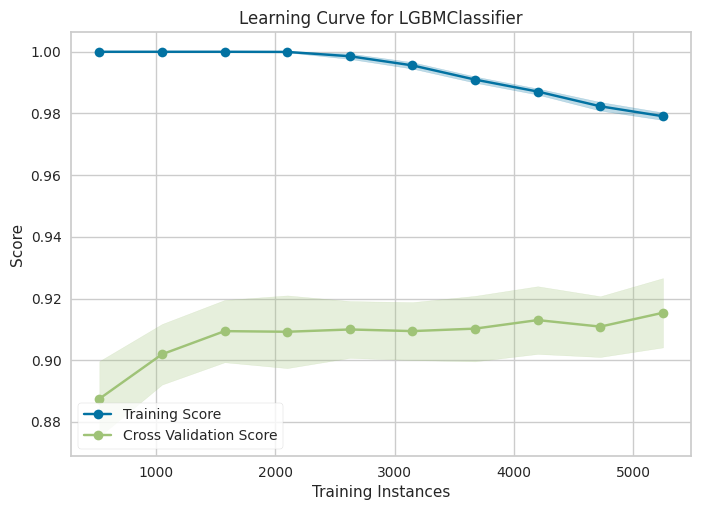

<Axes: title={'center': 'Learning Curve for LGBMClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [91]:
from yellowbrick.model_selection import LearningCurve
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10)
sizes = np.linspace(0.1, 1.0, 10)
model = LGBMClassifier(learning_rate=0.05, n_estimators=150, num_leaves=31, verbose=-1)
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X_train_tweedie, y_train_tweedie)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

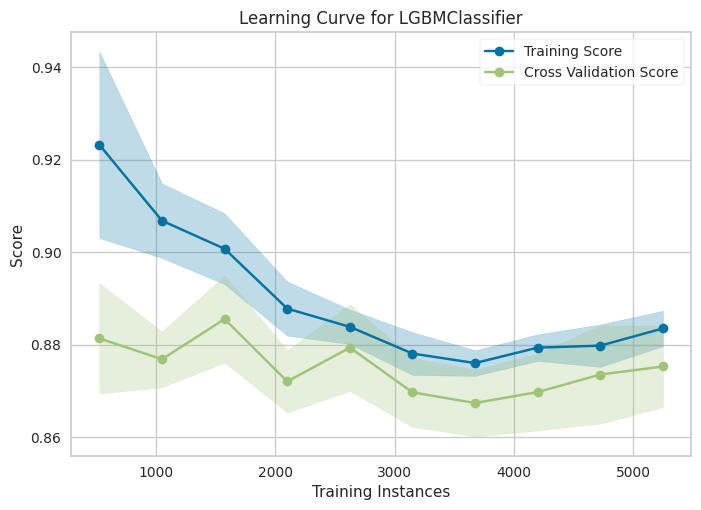

<Axes: title={'center': 'Learning Curve for LGBMClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [92]:
from yellowbrick.model_selection import LearningCurve
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10)
sizes = np.linspace(0.1, 1.0, 10)
model = LGBMClassifier(learning_rate=0.05, n_estimators=50, num_leaves=5, verbose=-1)
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X_train_tweedie, y_train_tweedie)        # Fit the data to the visualizer
visualizer.show()

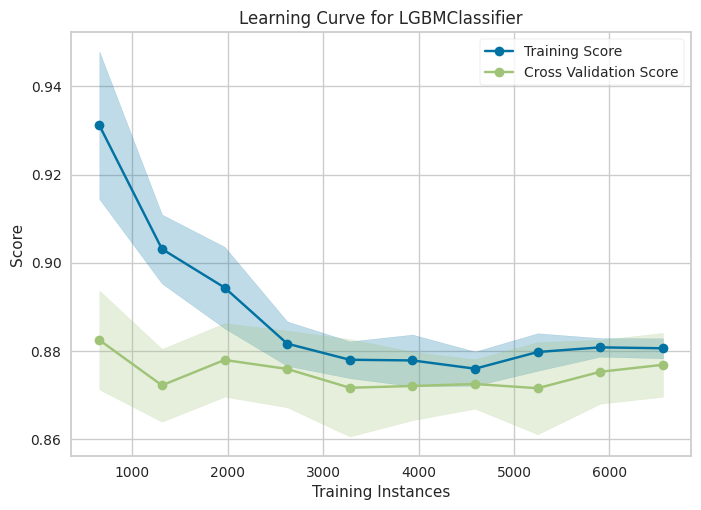

<Axes: title={'center': 'Learning Curve for LGBMClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [93]:
from yellowbrick.model_selection import LearningCurve
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10)
sizes = np.linspace(0.1, 1.0, 10)
model = LGBMClassifier(learning_rate=0.05, n_estimators=50, num_leaves=5, verbose=-1)
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(candidate_train_predictors_tweedie_updated_encoded, y_tweedie)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

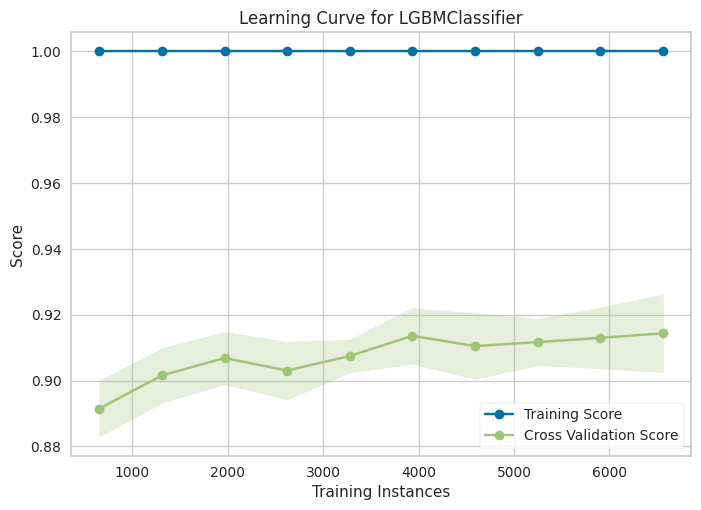

<Axes: title={'center': 'Learning Curve for LGBMClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [94]:
from yellowbrick.model_selection import LearningCurve
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10)
sizes = np.linspace(0.1, 1.0, 10)
model = LGBMClassifier(learning_rate=0.2, n_estimators=100, num_leaves=127, verbose=-1)
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(candidate_train_predictors_tweedie_updated_encoded, y_tweedie)        # Fit the data to the visualizer
visualizer.show() 

<Axes: >

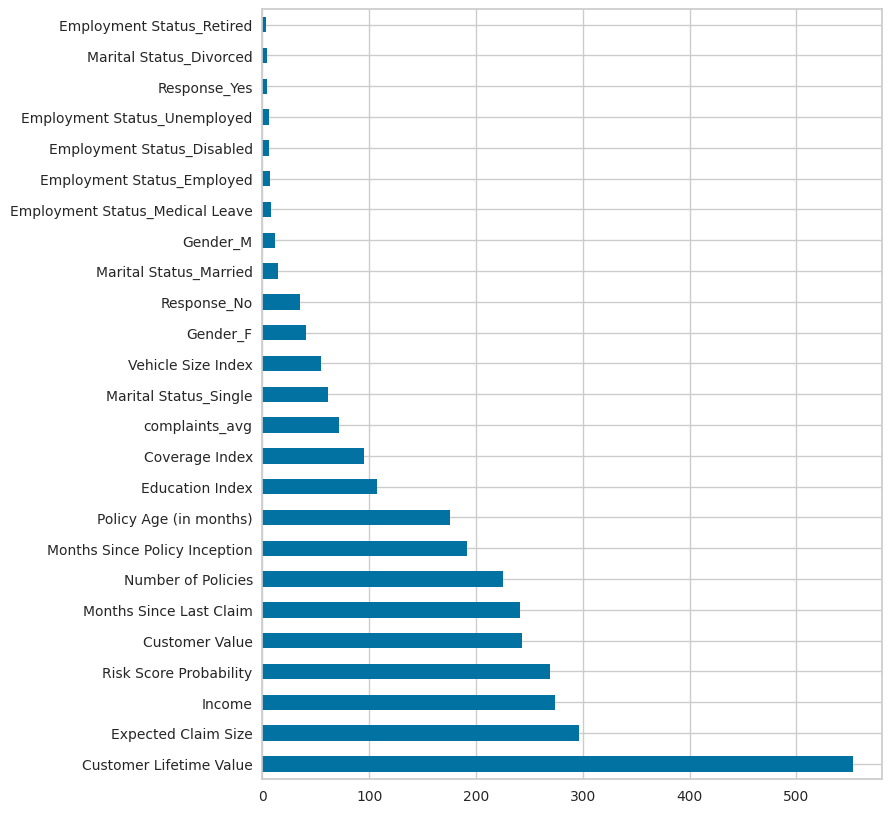

In [95]:
feat_imp = pd.Series(lgbm.feature_importances_, index=candidate_train_predictors_tweedie_updated_encoded.columns)
feat_imp.nlargest(30).plot(kind='barh', figsize=(8,10))

Expected claim size contributes a noticeable importance to the dataset, but not enough. there might still be underlying relationship between CLV and a feature that has not yet to be found.

In [96]:
# y_val_tweedie_df = pd.DataFrame(y_val_tweedie)

In [97]:
# # # tweedie with resampling  since we observe a quite high FN -> upsampling minority
# oversample = RandomOverSampler(sampling_strategy='minority')
# # fit and apply the transform
# X_train_tweedie_resampled, y_train_tweedie_resampled = oversample.fit_resample(candidate_train_predictors_tweedie_updated_encoded, y_tweedie)
# # Build the model with the random forest regression algorithm:
# lgbm = LGBMClassifier(objective='binary')
# lgbm.fit(X_train_tweedie_resampled, y_train_tweedie_resampled)
# val_y_predlgbm = lgbm.predict(X_val_tweedie)

# fpr, tpr, thresholds = metrics.roc_curve(y_val_tweedie, val_y_predlgbm_tweedie, pos_label=1)
# auc_roc = metrics.auc(fpr, tpr)
# precision, recall, _ = precision_recall_curve(y_val_tweedie, val_y_predlgbm_tweedie)
# auc_pr = auc(recall, precision)

# print("Recall of LightGBM on test set:",metrics.recall_score(y_val_tweedie, val_y_predlgbm_tweedie,average='binary')) 
# print('Precision of LightGBM on test set: {:.2f}'.format(precision_score(y_val_tweedie, val_y_predlgbm_tweedie))) 
# print('F1 score of LightGBM on test set: {:.2f}'.format(f1_score(y_val_tweedie, val_y_predlgbm_tweedie, average='weighted'))) # to account for disbalance

# print(f"ROC-AUC of LightGBM on test set: {auc_roc}")
# print(f"PR-AUC of LightGBM on test set: {auc_pr}")

In [98]:
# # grid search
# from sklearn.model_selection import GridSearchCV

# # Define the hyperparameter grid
# param_grid = {
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [-1, 5, 10, 15],
#     'n_estimators': [100, 150, 200],
#     'num_leaves': [31, 50, 100],
#     'min_child_samples': [20, 30, 50],  # New hyperparameter for controlling overfitting
#     'subsample': [0.6, 0.8, 1.0],  # To introduce randomness into training
# }

# # Initialize the model
# lgbm_2 = lgb.LGBMClassifier()

# # Setup the GridSearchCV
# grid_search = GridSearchCV(lgbm_2, param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)
# grid_search.fit(X_train_tweedie, y_train_tweedie)

# # Get the best parameters and model
# best_params_ = grid_search.best_params_
# best_model_ = grid_search.best_estimator_

In [99]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import roc_curve, auc, precision_recall_curve, recall_score, precision_score, f1_score, confusion_matrix
# from lightgbm import LGBMClassifier

# # Initialize the model
# lgbm = LGBMClassifier(objective='binary')

# # Stratified K-Fold Cross-Validation
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# fold_roc_aucs = []
# fold_pr_aucs = []

# # Iterate over the folds
# for train_index, val_index in skf.split(candidate_train_predictors_tweedie_updated_encoded, y_tweedie):
#     # Split the data
#     X_train_tweedie, X_val_tweedie = candidate_train_predictors_tweedie_updated_encoded.iloc[train_index], candidate_train_predictors_tweedie_updated_encoded.iloc[val_index]
#     y_train_tweedie, y_val_tweedie = y_tweedie.iloc[train_index], y_tweedie.iloc[val_index]

#     # Fit the model
#     lgbm.fit(X_train_tweedie, y_train_tweedie)

#     # Predict on validation set
#     val_y_predlgbm_tweedie = lgbm.predict(X_val_tweedie)
#     val_y_pred_prob = lgbm.predict_proba(X_val_tweedie)[:, 1]  # Get probabilities for ROC and PR curves

#     # Calculate ROC AUC
#     fpr, tpr, _ = roc_curve(y_val_tweedie, val_y_pred_prob, pos_label=1)
#     fold_roc_aucs.append(auc(fpr, tpr))

#     # Calculate PR AUC
#     precision, recall, _ = precision_recall_curve(y_val_tweedie, val_y_pred_prob)
#     fold_pr_aucs.append(auc(recall, precision))

#     # Print metrics for each fold
#     print("Recall of LightGBM on validation set:", recall_score(y_val_tweedie, val_y_predlgbm_tweedie, average='binary'))
#     print('Precision of LightGBM on validation set: {:.2f}'.format(precision_score(y_val_tweedie, val_y_predlgbm_tweedie)))
#     print('F1 score of LightGBM on validation set: {:.2f}'.format(f1_score(y_val_tweedie, val_y_predlgbm_tweedie, average='weighted')))

#     # Print confusion matrix
#     cm = confusion_matrix(y_val_tweedie, val_y_predlgbm_tweedie)
#     print("Confusion Matrix:")
#     print(cm)
#     print("-" * 40)  # Separator for readability

# # Calculate mean ROC AUC and PR AUC across all folds
# mean_roc_auc = np.mean(fold_roc_aucs)
# mean_pr_auc = np.mean(fold_pr_aucs)

# print(f"Mean ROC-AUC of LightGBM across all folds: {mean_roc_auc:.4f}")
# print(f"Mean PR-AUC of LightGBM across all folds: {mean_pr_auc:.4f}")


In [100]:
# # tuning but with resampled data with tweedie
# # tuning for better model performance for data with expected claim size derived from Tweedie regressor
# best_params = {'learning_rate': 0.05, 'max_depth': -1, 'n_estimators': 150, 'num_leaves': 31}
# best_model = lgb.LGBMClassifier(**best_params)
# best_model.fit(X_train_tweedie_resampled, y_train_tweedie_resampled)     # y_val_tweedie

# val_y_predlgbmht_tweedie = best_model.predict(X_val_tweedie)

# fpr, tpr, thresholds = metrics.roc_curve(y_val_tweedie, val_y_predlgbmht_tweedie, pos_label=1)
# auc_roc = metrics.auc(fpr, tpr)
# precision, recall, _ = precision_recall_curve(y_val_tweedie, val_y_predlgbmht_tweedie)
# auc_pr = auc(recall, precision)

# print("Recall of LightGBM on test set:",metrics.recall_score(y_val_tweedie, val_y_predlgbmht_tweedie,average='binary')) 
# print('Precision of LightGBM on test set: {:.2f}'.format(precision_score(y_val_tweedie, val_y_predlgbmht_tweedie))) 
# print('F1 score of LightGBM on test set: {:.2f}'.format(f1_score(y_val_tweedie, val_y_predlgbmht_tweedie, average='weighted'))) # to account for disbalance

# print(f"ROC-AUC of LightGBM on test set: {auc_roc}")
# print(f"PR-AUC of LightGBM on test set: {auc_pr}")

Expected claim size without doing Tweedie starting from here. remember doing train test split before resampling.

In [101]:
# df_ros

In [102]:
# # test new feature, drop risk score probability
# df_ros['Months Since Last Claim'] = df_ros['Months Since Last Claim'].replace(0, 1)
# df_ros['Months Since Policy Inception'] = df_ros['Months Since Policy Inception'].replace(0, 1)

# df_ros['Expected Claim Size'] = (df_ros['Customer Lifetime Value'] * (df_ros['Months Since Last Claim'] / df_ros['Months Since Policy Inception']) * np.log(1 + df_ros['Number of Policies']))

In [103]:
# df_ros

In [104]:
# # train test split and upsample minority to test new features
# from imblearn.over_sampling import RandomOverSampler
# from imblearn.under_sampling import RandomUnderSampler

# y = df_train['Claim over 1k']
# X = candidate_train_predictors_ros
# # train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.20, random_state=314, stratify=y)

# # ros = RandomOverSampler(random_state=42)
# # X_train_resampled, y_train_resampled = ros.fit_resample(train_X, train_y)

# # df_train_resampled = pd.concat([X_train_resampled, y_train_resampled], axis=1)

In [105]:
# for col in df_ros.columns:
#     print(df_ros[col].dtypes)

In [106]:
# df_train_ros = df_ros.drop('Claim over 1k', axis=1)

In [107]:
# numeric_feat = df_train_ros.select_dtypes(include=['int64', 'float64']).columns
# scaler = StandardScaler()
# df_train_ros[numeric_feat] = scaler.fit_transform(df_train_ros[numeric_feat])
# df_train_ros.head()

### If we know a policyholder has claim size of over 1000 or not, we want to do something about estimating their claim size based on other numeric features -> make a column indicating estimation of claim amount

In [108]:
# df_train_ros = pd.get_dummies(df_train_ros)
# y_ros = df_ros['Claim over 1k']
# X_ros = df_train_ros.copy()

In [109]:
# # extract for Tweedie
# y_ros_tweedie = X_train_ros['Expected Claim Size']
# X_ros_tweedie = X_train_ros.drop('Expected Claim Size', axis=1)

In [110]:
# X_ros_tweedie

In [111]:
# # new feature estimating their claim amount based on  Claim size over 1000
# from sklearn.linear_model import TweedieRegressor

# X_train_ros, X_val_ros, y_train_ros, y_val_ros = train_test_split(X_ros, y_ros, test_size=0.2, random_state=42)

# # for Tweedie
# X_train_ros_tweedie, X_val_ros_tweedie, y_train_ros_tweedie, y_val_ros_tweedie = train_test_split(X_ros_tweedie, y_ros_tweedie, test_size=0.2, random_state=42)

# # train
# tweedie_model = TweedieRegressor(power=1.5, alpha=0.5)
# tweedie_model.fit(X_train_ros_tweedie, y_train_ros_tweedie)

In [112]:
# X_train_ros

In [113]:
# X_val_ros

In [114]:
# # modeling with this new feature with the modeling pipeline given (catboost, lgbm, etc)
# lgbm = LGBMClassifier(objective='binary')
# lgbm.fit(X_train_ros, y_train_ros)
# val_y_predlgbm_ros = lgbm.predict(X_val_ros)

# fpr, tpr, thresholds = metrics.roc_curve(y_val_ros, val_y_predlgbm_ros, pos_label=1)
# auc_roc = metrics.auc(fpr, tpr)
# precision, recall, _ = precision_recall_curve(y_val_ros, val_y_predlgbm_ros)         # problem with consistent between samples y_val and y_pred 
# auc_pr = auc(recall, precision)

# print("Recall of LightGBM on test set:",metrics.recall_score(y_val_ros, val_y_predlgbm_ros,average='binary')) 
# print('Precision of LightGBM on test set: {:.2f}'.format(precision_score(y_val_ros, val_y_predlgbm_ros))) 
# print('F1 score of LightGBM on test set: {:.2f}'.format(f1_score(y_val_ros, val_y_predlgbm_ros, average='weighted'))) # to account for disbalance

# print(f"ROC-AUC of LightGBM on test set: {auc_roc}")
# print(f"PR-AUC of LightGBM on test set: {auc_pr}")

In [115]:
# conf_matrix = confusion_matrix(y_val_ros, val_y_predlgbm_ros)
# conf_matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
# plt.show()

FP high because we are doing the Expected Claim size wrong, since expected claim size we inferred seem to mostly go over 1000. investigate this.

In [116]:
# df_ros[['Claim over 1k', 'Expected Claim Size']]

In [117]:
# feat_imp = pd.Series(lgbm.feature_importances_, index=X_ros.columns)
# feat_imp.nlargest(30).plot(kind='barh', figsize=(8,10))

In [118]:
# best_params = {'learning_rate': 0.05, 'max_depth': -1, 'n_estimators': 150, 'num_leaves': 31}
# best_model = lgb.LGBMClassifier(**best_params)
# best_model.fit(X_train_ros, y_train_ros)

# val_y_predlgbmht_ros = best_model.predict(X_val_ros)

# fpr, tpr, thresholds = metrics.roc_curve(y_val_ros, val_y_predlgbmht_ros, pos_label=1)
# auc_roc = metrics.auc(fpr, tpr)
# precision, recall, _ = precision_recall_curve(y_val_ros, val_y_predlgbmht_ros)
# auc_pr = auc(recall, precision)

# print("Recall of LightGBM on test set:",metrics.recall_score(y_val_ros, val_y_predlgbmht_ros,average='binary')) 
# print('Precision of LightGBM on test set: {:.2f}'.format(precision_score(y_val_ros, val_y_predlgbmht_ros))) 
# print('F1 score of LightGBM on test set: {:.2f}'.format(f1_score(y_val_ros, val_y_predlgbmht_ros, average='weighted'))) # to account for disbalance

# print(f"ROC-AUC of LightGBM on test set: {auc_roc}")
# print(f"PR-AUC of LightGBM on test set: {auc_pr}")

In [119]:
# y = df_train['Claim over 1k']
# X = candidate_train_predictors
# train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.20, random_state=314, stratify=y)

In [120]:
# lgbm = LGBMClassifier(objective='binary')
# lgbm.fit(train_X,train_y)
# val_y_predlgbm = lgbm.predict(val_X)

# fpr, tpr, thresholds = metrics.roc_curve(val_y, val_y_predlgbm, pos_label=1)
# auc_roc = metrics.auc(fpr, tpr)
# precision, recall, _ = precision_recall_curve(val_y, val_y_predlgbm)
# auc_pr = auc(recall, precision)

# print("Recall of LightGBM on test set:",metrics.recall_score(val_y, val_y_predlgbm,average='binary')) 
# print('Precision of LightGBM on test set: {:.2f}'.format(precision_score(val_y, val_y_predlgbm))) 
# print('F1 score of LightGBM on test set: {:.2f}'.format(f1_score(val_y, val_y_predlgbm, average='weighted'))) # to account for disbalance

# print(f"ROC-AUC of LightGBM on test set: {auc_roc}")
# print(f"PR-AUC of LightGBM on test set: {auc_pr}")

In [121]:
# import shap
# explainer = shap.Explainer(lgbm)
# shap_values = explainer.shap_values(val_X)
# shap.summary_plot(shap_values[1], val_X)
# # shap.summary_plot(shap_values[1], val_X, max_display=15)

In [122]:
# feat_imp = pd.Series(lgbm.feature_importances_, index=X.columns)
# feat_imp.nlargest(30).plot(kind='barh', figsize=(8,10))

In [123]:
# from sklearn.model_selection import GridSearchCV

# # Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Define a range of values for the hyperparameters to search through
# param_grid = {
#     'num_leaves': [5, 20, 31, 63, 127],
#     "max_depth": [-1, 3, 5],
#     'learning_rate': [0.05, 0.1, 0.2],
#     'n_estimators': [50, 100, 150]
# }

# # Initialize an empty dictionary to store the best hyperparameters and their values
# best_hyperparameters = {}
# best_values = {}
 
# # Initialize the LightGBM classifier
# lgb_classifier = lgb.LGBMClassifier(objective='binary', random_state=42)
 
# # Initialize GridSearchCV for hyperparameters
# grid_search = GridSearchCV(estimator=lgb_classifier, param_grid=param_grid,
#                            scoring='accuracy', cv=5)
 
# # Fit the model to the training data to search for the best hyperparameters
# grid_search.fit(X_train, y_train)
 
# # Get the best hyperparameters and their values
# best_params = grid_search.best_params_
# best_hyperparameters = list(best_params.keys())
# best_values = list(best_params.values())

In [124]:
# best_params
# {'learning_rate': 0.2, 'max_depth': -1, 'n_estimators': 100, 'num_leaves': 127}
# {'learning_rate': 0.05, 'max_depth': -1, 'n_estimators': 150, 'num_leaves': 31}

In [125]:
# best_params = {'learning_rate': 0.05, 'max_depth': -1, 'n_estimators': 150, 'num_leaves': 31}
# best_model = lgb.LGBMClassifier(**best_params)
# best_model.fit(train_X, train_y)

# val_y_predlgbmht = best_model.predict(val_X)

# fpr, tpr, thresholds = metrics.roc_curve(val_y, val_y_predlgbmht, pos_label=1)
# auc_roc = metrics.auc(fpr, tpr)
# precision, recall, _ = precision_recall_curve(val_y, val_y_predlgbmht)
# auc_pr = auc(recall, precision)

# print("Recall of LightGBM on test set:",metrics.recall_score(val_y, val_y_predlgbmht,average='binary')) 
# print('Precision of LightGBM on test set: {:.2f}'.format(precision_score(val_y, val_y_predlgbmht))) 
# print('F1 score of LightGBM on test set: {:.2f}'.format(f1_score(val_y, val_y_predlgbmht, average='weighted'))) # to account for disbalance

# print(f"ROC-AUC of LightGBM on test set: {auc_roc}")
# print(f"PR-AUC of LightGBM on test set: {auc_pr}")

In [126]:
# print(f"Confusion matrix\n {confusion_matrix(val_y, val_y_predlgbm)}\n")

In [127]:
# predictions = best_model.predict(candidate_test_predictors)
# output = pd.DataFrame({'CustomerID': df_test.CustomerID, 'Claim over 1k': predictions})
# output.to_csv('submission.csv', index=False)

In [128]:
# from yellowbrick.model_selection import LearningCurve
# from sklearn.model_selection import StratifiedKFold
# cv = StratifiedKFold(n_splits=10)
# sizes = np.linspace(0.1, 1.0, 10)
# model = LGBMClassifier(learning_rate=0.05, n_estimators=150, num_leaves=31, verbose=-1)
# visualizer = LearningCurve(
#     model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
# )

# visualizer.fit(train_X, train_y)        # Fit the data to the visualizer
# visualizer.show()           # Finalize and render the figure

In [129]:
# from yellowbrick.model_selection import LearningCurve
# from sklearn.model_selection import StratifiedKFold
# cv = StratifiedKFold(n_splits=10)
# sizes = np.linspace(0.1, 1.0, 10)
# model = LGBMClassifier(learning_rate=0.05, n_estimators=50, num_leaves=5, verbose=-1)
# visualizer = LearningCurve(
#     model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
# )

# visualizer.fit(train_X, train_y)        # Fit the data to the visualizer
# visualizer.show()           # Finalize and render the figure

In [130]:
# from yellowbrick.model_selection import LearningCurve
# from sklearn.model_selection import StratifiedKFold
# cv = StratifiedKFold(n_splits=10)
# sizes = np.linspace(0.1, 1.0, 10)
# model = LGBMClassifier(learning_rate=0.05, n_estimators=50, num_leaves=5, verbose=-1)
# visualizer = LearningCurve(
#     model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
# )

# visualizer.fit(X, y)        # Fit the data to the visualizer
# visualizer.show()           # Finalize and render the figure

In [131]:
# from yellowbrick.model_selection import LearningCurve
# from sklearn.model_selection import StratifiedKFold
# cv = StratifiedKFold(n_splits=10)
# sizes = np.linspace(0.1, 1.0, 10)
# model = LGBMClassifier(learning_rate=0.2, n_estimators=100, num_leaves=127, verbose=-1)
# visualizer = LearningCurve(
#     model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
# )

# visualizer.fit(X, y)        # Fit the data to the visualizer
# visualizer.show()           # Finalize and render the figure

In [132]:
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import RandomOverSampler

In [133]:
# oversample = RandomOverSampler(sampling_strategy='minority')
# # fit and apply the transform
# train_X, train_y = oversample.fit_resample(X, y)
# # Build the model with the random forest regression algorithm:
# lgbm = LGBMClassifier(objective='binary')
# lgbm.fit(train_X,train_y)
# val_y_predlgbm = lgbm.predict(val_X)

# fpr, tpr, thresholds = metrics.roc_curve(val_y, val_y_predlgbm, pos_label=1)
# auc_roc = metrics.auc(fpr, tpr)
# precision, recall, _ = precision_recall_curve(val_y, val_y_predlgbm)
# auc_pr = auc(recall, precision)

# print("Recall of LightGBM on test set:",metrics.recall_score(val_y, val_y_predlgbm,average='binary')) 
# print('Precision of LightGBM on test set: {:.2f}'.format(precision_score(val_y, val_y_predlgbm))) 
# print('F1 score of LightGBM on test set: {:.2f}'.format(f1_score(val_y, val_y_predlgbm, average='weighted'))) # to account for disbalance

# print(f"ROC-AUC of LightGBM on test set: {auc_roc}")
# print(f"PR-AUC of LightGBM on test set: {auc_pr}")

In [134]:
# from yellowbrick.model_selection import LearningCurve
# from sklearn.model_selection import StratifiedKFold
# cv = StratifiedKFold(n_splits=10)
# sizes = np.linspace(0.1, 1.0, 10)
# model = LGBMClassifier(learning_rate=0.05, n_estimators=50, num_leaves=5, verbose=-1)
# visualizer = LearningCurve(
#     model, cv=cv, scoring='recall', train_sizes=sizes, n_jobs=4
# )

# visualizer.fit(train_X, train_y)        # Fit the data to the visualizer
# visualizer.show()           # Finalize and render the figure

In [135]:
# from sklearn.metrics import confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns

# conf_matrix = confusion_matrix(val_y, val_y_predlgbm)
# conf_matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
# plt.show()

In [136]:
# print(conf_matrix)

In [137]:
# import shap
# explainer = shap.Explainer(lgbm)
# shap_values = explainer.shap_values(val_X)
# shap.summary_plot(shap_values[1], val_X, max_display=15)

In [138]:
# predictions = lgbm.predict(candidate_test_predictors)
# output = pd.DataFrame({'CustomerID': df_test.CustomerID, 'Claim over 1k': predictions})
# output.to_csv('submission.csv', index=False)

In [139]:
# # https://www.kaggle.com/code/mlisovyi/beware-of-categorical-features-in-lgbm
# fit_params={"eval_metric" : 'auc', 
#             "eval_set" : [(val_X,val_y)],
#             'eval_names': ['valid'],
#             'feature_name': 'auto', # that's actually the default
#             'categorical_feature': ['State', 'Response', 'Coverage', 'Education', 'Employment Status',
#        'Gender', 'Marital Status', 'Policy Type', 'Policy', 'Sales Channel',
#        'Vehicle Size', 'Renew Offer Type']
#            }

In [140]:
# #n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 1000 define only the absolute maximum
# clf = lgb.LGBMClassifier(num_leaves= 15, max_depth=-1, 
#                          random_state=314, 
#                          silent=True, 
#                          metric='None', 
#                          n_jobs=4, 
#                          n_estimators=1000,
#                          colsample_bytree=0.9,
#                          subsample=0.9,
#                          learning_rate=0.1)

In [141]:
# #force larger number of max trees and smaller learning rate
# clf.fit(train_X, train_y, **fit_params)

# val_y_predlgbm = lgbm.predict(val_X)

# fpr, tpr, thresholds = metrics.roc_curve(val_y, val_y_predlgbm, pos_label=1)
# auc_roc = metrics.auc(fpr, tpr)
# precision, recall, _ = precision_recall_curve(val_y, val_y_predlgbm)
# auc_pr = auc(recall, precision)

# print("Recall of LightGBM on test set:",metrics.recall_score(val_y, val_y_predlgbm,average='binary')) 
# print('Precision of LightGBM on test set: {:.2f}'.format(precision_score(val_y, val_y_predlgbm))) 
# print('F1 score of LightGBM on test set: {:.2f}'.format(f1_score(val_y, val_y_predlgbm, average='weighted'))) # to account for disbalance

# print(f"ROC-AUC of LightGBM on test set: {auc_roc}")
# print(f"PR-AUC of LightGBM on test set: {auc_pr}")

In [142]:
# predictions = clf.predict(candidate_test_predictors)
# output = pd.DataFrame({'CustomerID': df_test.CustomerID, 'Claim over 1k': predictions})
# output.to_csv('submission.csv', index=False)